In [284]:
## After many chabhes needed to be checked what i actually use in this version 
#it includes also clening the memory 
import numpy as np
import matplotlib.pyplot as plts
import imageio as io #under a question
import cv2 
import PIL 
from scipy.optimize import curve_fit
import os
from PIL import Image
import math
import matplotlib.patches as patches
import json
import os, shutil
import glob
from scipy.signal import argrelextrema
#from scipy.signal import find_peaks
from statistics import mean 
import pandas as pd
from numpy import asarray
from numpy import savetxt
import pandas as pd
from scipy.optimize import curve_fit
import gc 
gc.collect()
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties
from matplotlib.transforms import ScaledTranslation
#from astropy.io import ascii
#from astropy.table import QTable, Table, Column

#for ROI
import matplotlib.pyplot as plt 
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path

In [285]:
 ## Paths to be used:
#ASCII file with GB, I loaded firstly into MATLAB ( program from Janelia) and saved only 4 needed col then I will use this file
file_name_beads='Run1-647_561_c123_sum_X21_processed_overlay_purged_IDL_ASCII.txt'
parent_dir_init='/Volumes/Elements/2024 August Gold Beads ASCII from Hari'
parent_dir = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21" 
path_to_beads = os.path.join(parent_dir_init, file_name_beads)


In [286]:
# Loading the data into a DataFrame, automatically using the first row as column names
data_beads = pd.read_csv(path_to_beads, delimiter='\t', low_memory=False) 
print('Data is loaded')
#data_beads = data_beads.dropna(subset=['LabelSet'])



Data is loaded


In [287]:
data_beads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20799527 entries, 0 to 20799526
Data columns (total 49 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Offset                   float64
 1   Amplitude                float64
 2   X Position               float64
 3   Y Position               float64
 4   X Peak Width             float64
 5   Y Peak Width             float64
 6   6 N Photons              float64
 7   ChiSquared               float64
 8   FitOK                    float64
 9   Frame Number             float64
 10  Peak Index of Frame      float64
 11  Peak Global Index        float64
 12  12 X PkW * Y PkW         float64
 13  Sigma Amplitude          float64
 14  Sigma X Pos rtNph        float64
 15  Sigma Y Pos rtNph        float64
 16  Sigma X Pos Full         float64
 17  Sigma Y Pos Full         float64
 18  18 Grouped Index         float64
 19  Group X Position         float64
 20  Group Y Position         float64
 21  Group 

In [288]:
columns_to_keep = ['Unwrapped Z', 'X Position', 'Y Position', 'Label Set']
data = data_beads[columns_to_keep].copy()

# Delete the initial data to free up memory, because it is too heavy
del data_beads
#Cleaning memory
gc.collect()
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20799527 entries, 0 to 20799526
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unwrapped Z  float64
 1   X Position   float64
 2   Y Position   float64
 3   Label Set    float64
dtypes: float64(4)
memory usage: 634.8 MB
None


In [289]:
# Rename the columns because in the file sent by Janelia col called differently from "our version", in order not to correct code further
data.rename(columns={
    'Unwrapped Z': 'UnwrappedZ',
    'X Position': 'XPosition',
    'Y Position': 'YPosition',
    'Label Set': 'LabelSet',
}, inplace=True)
data['XPosition'] = data['XPosition'].astype(int)
data['YPosition'] = data['YPosition'].astype(int)

In [290]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20799527 entries, 0 to 20799526
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   UnwrappedZ  float64
 1   XPosition   int64  
 2   YPosition   int64  
 3   LabelSet    float64
dtypes: float64(2), int64(2)
memory usage: 634.8 MB
None


In [291]:
# set the ch info, colors, scales
ch_name = ["Vinculin","Vimentin"]
ch_col = ['deepskyblue',"orange"]

#scale x and y with 133nm per unit, seams not neede for data with GB
#unit_nm = 133
#unit_mkm=0.133
#just from nm to mkm
new_unit_mkm=0.001

In [292]:
#data['XPosition_nm'] =np.round(data['XPosition'] * unit_nm,2)
data['XPosition_mkm'] =np.round(data['XPosition'] * new_unit_mkm,3)

#data['YPosition_nm'] =np.round(data['YPosition'] * unit_nm,2)
data['YPosition_mkm'] =np.round(data['YPosition'] * new_unit_mkm,3)
data = data.dropna(subset=['LabelSet'])
data['LabelSet'] = data['LabelSet'].astype(int)
print(data.head())

   UnwrappedZ  XPosition  YPosition  LabelSet  XPosition_mkm  YPosition_mkm
0     296.218      11394      36640         1         11.394         36.640
1     239.951      18621      38253         1         18.621         38.253
2     311.746       1058      37314         1          1.058         37.314
3     479.941      23283      47283         1         23.283         47.283
4     244.446      22870      49129         1         22.870         49.129


## Devide data to 2 ch
### ["Vinculin","Vimentin"] by default if the oder is different:
change data_table_ch1 to data_table_ch2 and data_table_ch2 to data_table_ch1

In [293]:
# function to get ONLY unique values, needed to further CHs separation
def uniqueValues(listOFdata):
    unique_data = pd.Series(listOFdata).drop_duplicates().tolist()
    return unique_data
        

# call the function to see Chs indexes 
label_set_index = uniqueValues(data['LabelSet'])
print('NOTE: only one CH is detected') if (len(label_set_index))==1 else print(str(len(label_set_index))+' CHs are detected')


2 CHs are detected


In [294]:
#devide data to 2 ch
mask_ch1 = data['LabelSet'] ==label_set_index[0]    # Makes a boolean selection mask 
mask_ch2 = data['LabelSet'] ==label_set_index[1] 

#["Vinculin","Vimentin"] by default if the oder is different change data_table_ch1 to data_table_ch2 and data_table_ch2 to data_table_ch1
data_table_ch1 = data[mask_ch1]   # Makes a new astropy Table for ch1
data_table_ch2 = data[mask_ch2]   # Makes a new astropy Table for ch2


print('only one CH is detected') if (len(label_set_index))==1 or len(data_table_ch2)<100 else print(str(len(label_set_index))+' CHs are detected')
print('CH(s) data- OK') if (len(data_table_ch2)+len(data_table_ch1))==(len(data['LabelSet']) ) else print("There may be more then 2 CHs, or mistake in separation")


print("number of data for CH1",len(data_table_ch1))
print("number of data for CH2", len(data_table_ch2))

2 CHs are detected
CH(s) data- OK
number of data for CH1 13744463
number of data for CH2 7055064


In [295]:
# z -slice set by z_range_const, starts from 0
z_range_const=700

data_table_ch1_range = data_table_ch1[data_table_ch1['UnwrappedZ']<=z_range_const]   # Makes a new astropy Table
data_table_ch1_range = data_table_ch1_range[data_table_ch1_range['UnwrappedZ']>= 0]

#check the Z is in between range (0,z_range_const)
print('Z range ch1 = (', data_table_ch1_range['UnwrappedZ'].min(), ',', data_table_ch1_range['UnwrappedZ'].max(), ')')

data_table_ch2_range = data_table_ch2[data_table_ch2['UnwrappedZ']<=z_range_const]   # Makes a new astropy Table
data_table_ch2_range = data_table_ch2_range[data_table_ch2_range['UnwrappedZ']>= 0]

#check the Z is in between range (0,z_range_const)
print('Z range ch2 = (', data_table_ch2_range['UnwrappedZ'].min(), ',', data_table_ch2_range['UnwrappedZ'].max(), ')')

Z range ch1 = ( 0.00299072 , 683.771 )
Z range ch2 = ( 0.00490105 , 666.589 )


In [296]:
# mandatory to run, definitions, in use but in simplified version for question to janelia not sure if it is used, so run anyway
x_data_ch1_range = data_table_ch1_range['XPosition']
y_data_ch1_range = data_table_ch1_range['YPosition']
z_data_ch1_range = data_table_ch1_range['UnwrappedZ']
#x_data_ch1_range_nm = data_table_ch1_range['XPosition_nm']
#y_data_ch1_range_nm = data_table_ch1_range['YPosition_nm']
x_data_ch1_range_mkm = data_table_ch1_range['XPosition_mkm']
y_data_ch1_range_mkm = data_table_ch1_range['YPosition_mkm']

x_data_ch2_range = data_table_ch2_range['XPosition']
y_data_ch2_range = data_table_ch2_range['YPosition']
z_data_ch2_range = data_table_ch2_range['UnwrappedZ']
#x_data_ch2_range_nm = data_table_ch2_range['XPosition_nm']
#y_data_ch2_range_nm = data_table_ch2_range['YPosition_nm']
x_data_ch2_range_mkm = data_table_ch2_range['XPosition_mkm']
y_data_ch2_range_mkm = data_table_ch2_range['YPosition_mkm']

In [50]:
parent_dir

'/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21'

## Plot projection via the z range (0:z_range_const) 

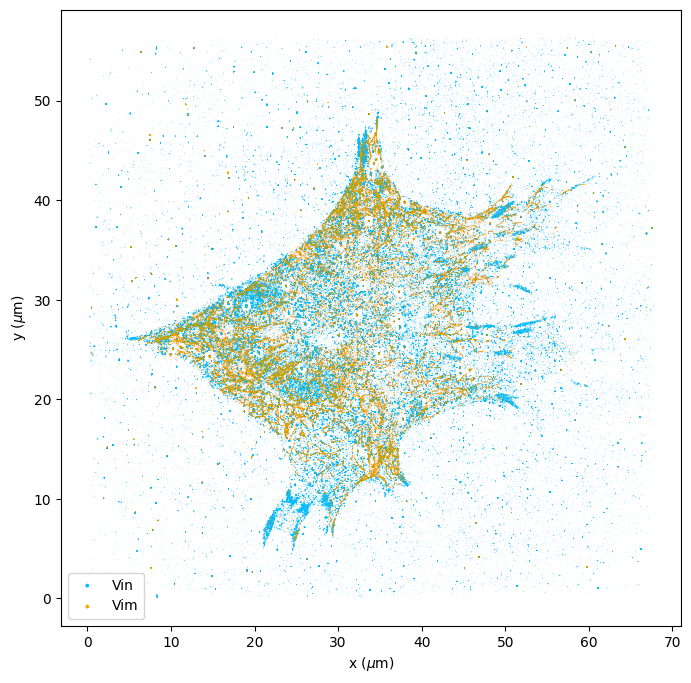

In [51]:
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('default')
    
mkm=0.001
x1 = x_data_ch1_range_mkm
y1 = y_data_ch1_range_mkm

x2 = x_data_ch2_range_mkm
y2 = y_data_ch2_range_mkm

fig1, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x1, y1,  s=0.2, label= ch_name[0][:3],marker='.', color= ch_col[0],edgecolors='none')
ax.scatter(x2, y2, s=0.05, label= ch_name[1][:3],marker='.', color= ch_col[1],alpha=1,edgecolors='none')

plt.xlabel(r'x ($\mu $m)')
plt.ylabel(r'y ($\mu $m)')
title3D="2 ch 3D in the range(0:" + str(z_range_const) + ")"
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
#save fig with ROI
#plt.close(fig)
file_name_range = '/zrange_0_'+str(z_range_const)
fig1.savefig(parent_dir+ file_name_range+'_whole_cells_white_mask.png',dpi=600)

plt.show()




# Ploting hist for both CHs for whole cell within z range, defining Z centre
## +Same but for normalised hist. 
It is needed to make channels data comparison easier, the counts in the histogram are normalized in a way that the area under the histogram is equal to 1 to form kind of probability density. All these for whole cell so one pick gaus. approximation will not work properly but his visualisation helps to understand the data

In [297]:
%matplotlib inline
# Define the Gauss. function
def gauss_f(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))


In [298]:
def fit_and_plot(ax, data, bins, color, channel_name, normalize=False):
    n, bins, patches = ax.hist(data, bins=bins, color=color, label=channel_name, density=normalize)
    
    # Initial guess for the Gaussian parameters
    y_data_max = n.max()
    x_max_index = np.argmax(n)
    max_posit = bins[x_max_index] + np.diff(bins)[0] / 2  # Center of the bin
    initial_guess = [y_data_max, max_posit, np.std(data)]

    # Prepare the x data for the fit (bin centers)
    x_data = bins[:-1] + np.diff(bins) / 2
    popt, _ = curve_fit(gauss_f, x_data, n, p0=initial_guess)
    
    # Generate model data for the fit curve
    x_model = np.linspace(0, z_range_const, z_range_const)
    y_model = gauss_f(x_model, *popt)
    
    # Plot the Gaussian fit
    ax.plot(x_model, y_model, label='Gaussian fit', color="black", linewidth=3)
    ax.set_ylim(0, (y_data_max + 0.5 * y_data_max))

    # Display z-center as a point with SD as error bars
    y_center = gauss_f(popt[1], *popt)
    ax.errorbar(popt[1], y_center, xerr=popt[2], fmt='o', color='black', capsize=5, label='Z centre ± SD')

    # Drawing z-center ± SD lines to the height where SD on the fit
    sd_pos = popt[1] + popt[2]  # z-center + SD
    sd_neg = popt[1] - popt[2]  # z-center - SD
    y_sd_pos = gauss_f(sd_pos, *popt)
    y_sd_neg = gauss_f(sd_neg, *popt)

    # Draw vertical lines for z-center ± SD
    ax.vlines(sd_pos, 0, y_sd_pos, colors='black', linestyles='dashed')
    ax.vlines(sd_neg, 0, y_sd_neg, colors='black', linestyles='dashed')

    # Add results to the graph as text
    results_z0 = "Z centre= {:.2f}".format(popt[1])
    results_sd = "SD= {:.2f}".format(popt[2])
    label_coord_y = 1.35 * y_data_max
    ax.text(x_model.max() - 300, label_coord_y, results_z0, fontsize=12)
    ax.text(x_model.max() - 300, label_coord_y - 0.1 * label_coord_y, results_sd, fontsize=12)
    ax.set(xlabel='z (nm)', ylabel='Probability density' if normalize else 'Number of localizations')
    ax.legend(loc='upper left', fontsize=12)

    return popt  # Ensure this line is added


Non-normalized histogram output file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21


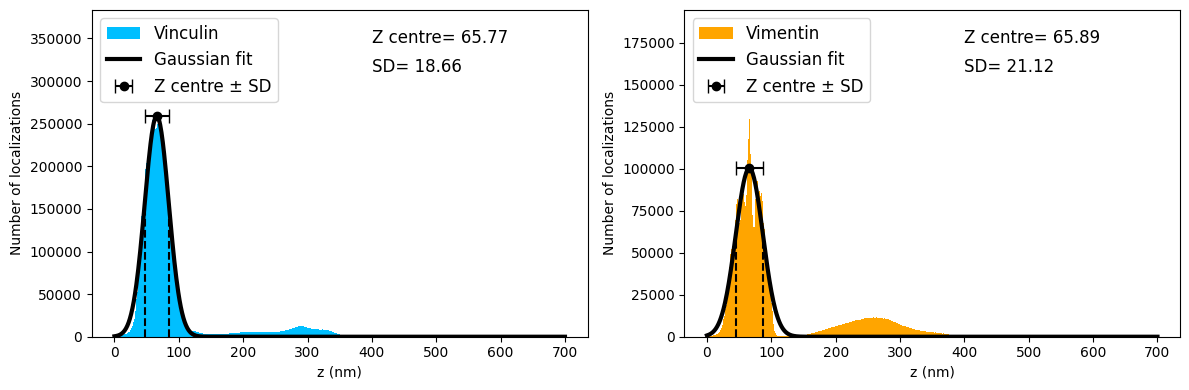

Normalized histogram output file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21


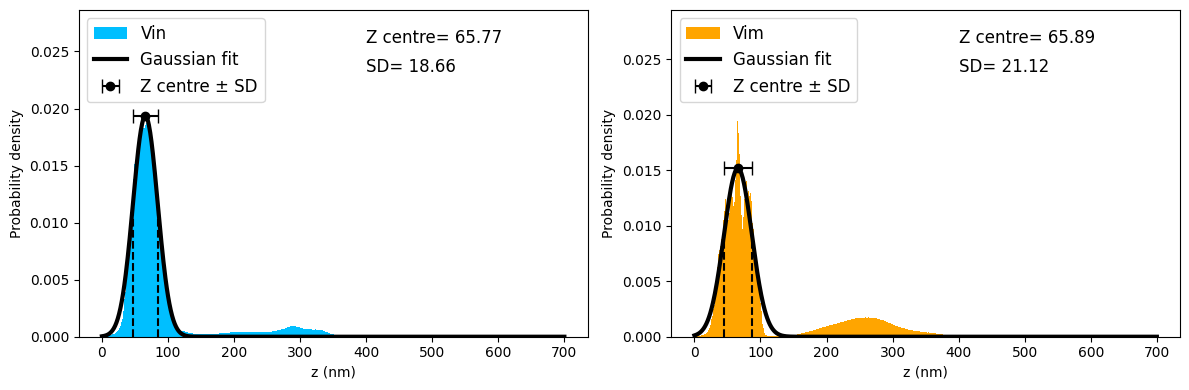

In [299]:
plt.style.use('default') #change if you want for example dark background

# Define the number of bins such that it gives 1nm in between bins
his_bins = z_range_const

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))

# Gauss. fit and plot for each ch for non-normalized histogram
popt_ch1_wc = fit_and_plot(ax1[0], data_table_ch1_range['UnwrappedZ'], his_bins, ch_col[0], ch_name[0])
popt_ch2_wc = fit_and_plot(ax1[1], data_table_ch2_range['UnwrappedZ'], his_bins, ch_col[1], ch_name[1])

# Save the non-normalized histogram plot
plt.tight_layout()
plt.savefig(parent_dir + "/whole_cells_z0_over_a_selectedRange_his.png")
print("Non-normalized histogram output file saved in the directory:", parent_dir)
plt.show()
plt.close(fig1)  # Close the figure to free up memory

# Create subplots for normalized histograms
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
# Perform Gaussian fit and plot for each channel for normalized histogram, normalize=True
popt_ch1_norm_wc = fit_and_plot(ax2[0], data_table_ch1_range['UnwrappedZ'], his_bins, ch_col[0], ch_name[0][:3], normalize=True)
popt_ch2_norm_wc = fit_and_plot(ax2[1], data_table_ch2_range['UnwrappedZ'], his_bins, ch_col[1], ch_name[1][:3], normalize=True)
# Save the normalized histogram plot
plt.tight_layout()
plt.savefig(parent_dir + "/whole_cells_z0_over_a_selectedRange_his_normalized.png")
print("Normalized histogram output file saved in the directory:", parent_dir)
plt.show()
plt.close(fig2) 

# Unpack the parameters for further use
A_opt_ch1_wc, mu_opt_ch1_wc, sig_opt_ch1_wc = popt_ch1_wc
A_opt_ch2_wc, mu_opt_ch2_wc, sig_opt_ch2_wc = popt_ch2_wc


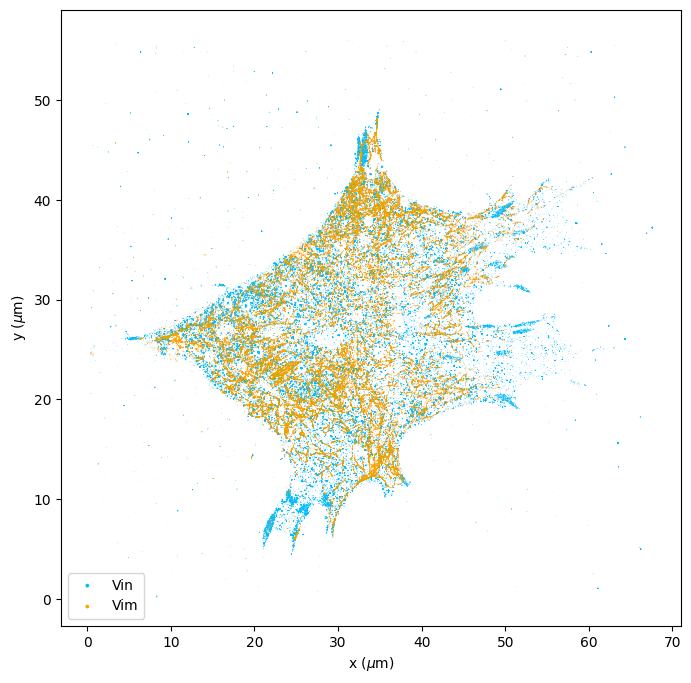

In [300]:
# select data and plot for Z in the range
z0=200
z_slice=300
data_Zselection_ch1 = data_table_ch1_range[(data_table_ch1_range['UnwrappedZ'] >= z0) & (data_table_ch1_range['UnwrappedZ'] <= z_slice)]
data_Zselection_ch2 = data_table_ch2_range[(data_table_ch2_range['UnwrappedZ'] >= z0) & (data_table_ch2_range['UnwrappedZ'] <= z_slice)]

x1 = data_Zselection_ch1['XPosition_mkm']
y1 = data_Zselection_ch1['YPosition_mkm']

x2 = data_Zselection_ch2['XPosition_mkm']
y2 = data_Zselection_ch2['YPosition_mkm']

fig1, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x1, y1,  s=0.3, label= ch_name[0][:3],marker='.', color= ch_col[0],edgecolors='none')
ax.scatter(x2, y2, s=0.1, label= ch_name[1][:3],marker='.', color= ch_col[1],alpha=1,edgecolors='none')

plt.xlabel(r'x ($\mu $m)')
plt.ylabel(r'y ($\mu $m)')
title3D="2 ch 3D in the range(0:" + str(z_range_const) + ")"
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
#save fig with ROI
#plt.close(fig)
file_name_range = '/zrange_0_'+str(z_range_const)
fig1.savefig(parent_dir+ file_name_range+'_whole_cells_whiterange.png',dpi=600)

plt.show()

In [16]:
parent_dir

'/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21'

# GB z correction

In [303]:
## Path to be used:
file_name_tiff = 'Run1-647_561_c123_sum_X21_processed_overlay_IDL.tiff'
tiff_path = os.path.join(parent_dir, file_name_tiff)
# Show the first few rows of the DataFrame to verify
print(tiff_path)

parent_dir='/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction'

/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction/Run1-647_561_c123_sum_X21_processed_overlay_IDL.tiff


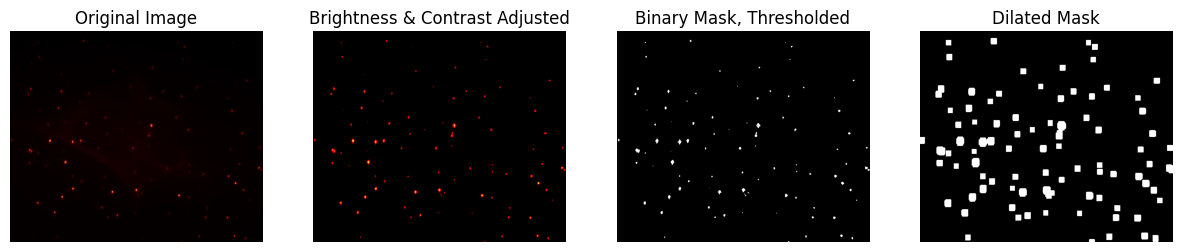

In [304]:
#Loadng tiff from file, adjusting brightness/ contrast, making binary mask
%matplotlib inline
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow
        image = cv2.addWeighted(image, alpha_b, image, 0, gamma_b)

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        image = cv2.addWeighted(image, alpha_c, image, 0, gamma_c)

    return image

image = cv2.imread(tiff_path, cv2.IMREAD_UNCHANGED)
image = cv2.flip(image, 0)

if image is None:
    raise FileNotFoundError(f"File not found or unable to read: {tiff_path}")

brightness_factor = 100  # Adjust brightness [-255, 255]
contrast_factor = 120    # Adjust contrast [-127, 127]
image_adjusted = adjust_brightness_contrast(image, brightness=brightness_factor, contrast=contrast_factor)

# Convert to gs
if len(image_adjusted.shape) == 3:
    image_gray = cv2.cvtColor(image_adjusted, cv2.COLOR_BGR2GRAY)
else:
    image_gray = image_adjusted

# Thresholding
threshold_value = 50  # Adjust threshold
_, binary_mask = cv2.threshold(image_gray, threshold_value, 255, cv2.THRESH_BINARY)

# Apply dilation to expand the white areas
kernel_size = 10  # For control the amount of dilation
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

if len(image.shape) == 2:
    axes[0].imshow(image, cmap='gray')
else:
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

if len(image.shape) == 2:
    axes[1].imshow(image_adjusted, cmap='gray')
else:
    axes[1].imshow(cv2.cvtColor(image_adjusted, cv2.COLOR_BGR2RGB))
axes[1].set_title('Brightness & Contrast Adjusted')
axes[1].axis('off')

axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Binary Mask, Thresholded')
axes[2].axis('off')

axes[3].imshow(dilated_mask, cmap='gray')
axes[3].set_title('Dilated Mask')
axes[3].axis('off')

plt.show()


In [305]:
binary_mask=dilated_mask

/var/folders/_y/_0mkw2hs01z8ssfb0kcwd9k00000gn/T/ipykernel_4053/173989207.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/opt/anaconda3/envs/Arun_GB/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


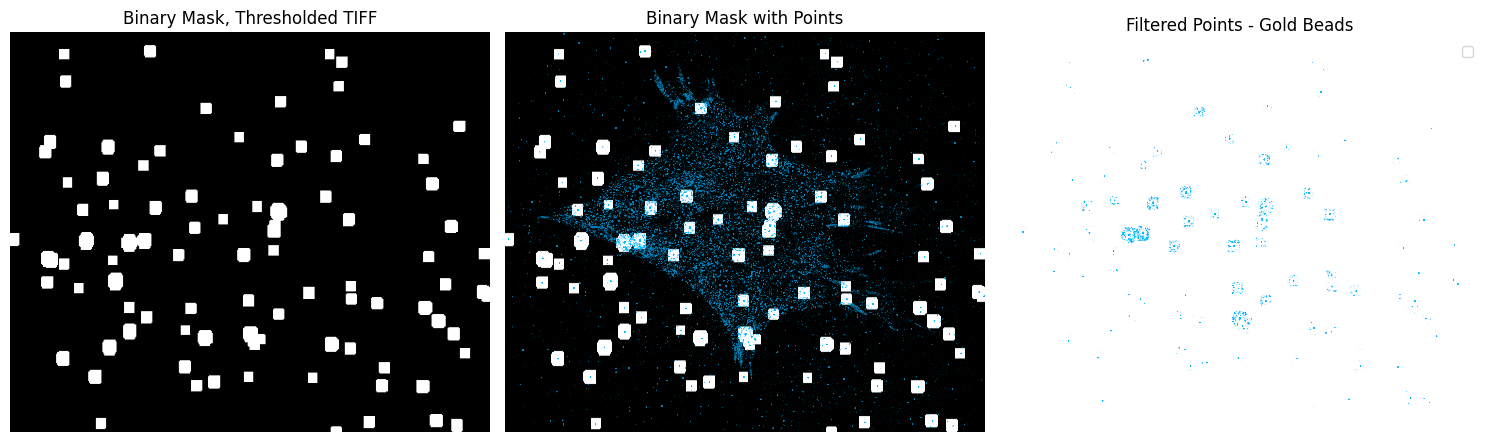

In [306]:
px = 133
scaled_mask = cv2.resize(binary_mask, (image_gray.shape[1] * px, image_gray.shape[0] * px), interpolation=cv2.INTER_NEAREST)

# Convert (x, y) scatter plot data to mask coordinates
x = data_table_ch1_range['XPosition'].astype(int)
y = data_table_ch1_range['YPosition'].astype(int)

# Ensure coordinates do not go out of bounds after scaling
max_x = scaled_mask.shape[1] - 1
max_y = scaled_mask.shape[0] - 1

# Clip x and y to be within bounds
x = np.clip(x, 0, max_x)
y = np.clip(y, 0, max_y)

mask_values = scaled_mask[y, x]

# Apply the mask to filter points
filtered_x = x[mask_values == 255]
filtered_y = y[mask_values == 255]

# Create a new DataFrame with the filtered data
filtered_data = data_table_ch1_range[(mask_values == 255)]

# Save the filtered DataFrame to a file
filtered_data.to_csv('filtered_data.csv', index=False)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('Binary Mask, Thresholded TIFF')
axes[0].axis('off')

axes[1].imshow(scaled_mask, cmap='gray')
axes[1].scatter(x, y, s=0.05, label= ch_name[0][:3],marker='.', color= ch_col[0],edgecolors='none')
axes[1].set_title('Binary Mask with Points')
axes[1].axis('off')

axes[2].scatter(filtered_x, filtered_y, marker='.', s=0.05, color= ch_col[0], edgecolors='none')
axes[2].set_title('Filtered Points - Gold Beads')
axes[2].axis('off')
axes[2].invert_yaxis()
axes[2].set_aspect('equal', 'box')
plt.savefig(parent_dir+ "//Gb_select_ch1_process.png", dpi=300)
plt.tight_layout()

plt.legend()
#plt.close()
plt.show()

In [307]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5192214 entries, 8 to 13744460
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   UnwrappedZ     float64
 1   XPosition      int64  
 2   YPosition      int64  
 3   LabelSet       int64  
 4   XPosition_mkm  float64
 5   YPosition_mkm  float64
dtypes: float64(3), int64(3)
memory usage: 277.3 MB


/var/folders/_y/_0mkw2hs01z8ssfb0kcwd9k00000gn/T/ipykernel_4053/429567961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


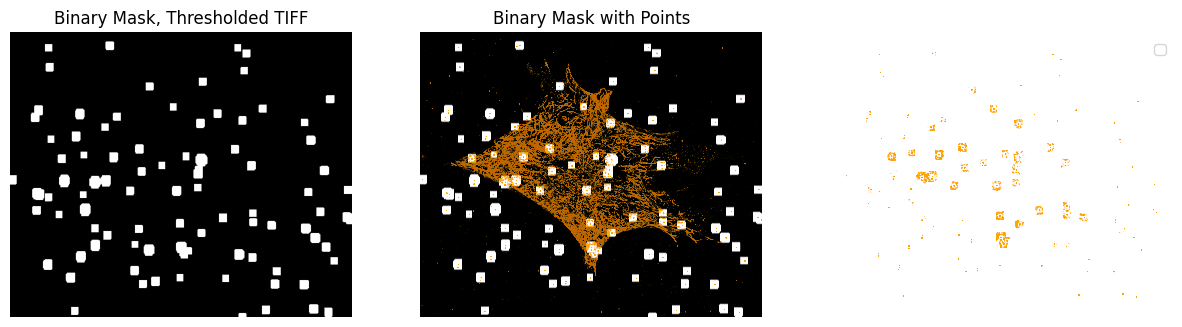

In [308]:
px = 133
scaled_mask = cv2.resize(binary_mask, (image_gray.shape[1] * px, image_gray.shape[0] * px), interpolation=cv2.INTER_NEAREST)

# Convert (x, y) scatter plot data to mask coordinates
x2 = data_table_ch2_range['XPosition'].astype(int)
y2 = data_table_ch2_range['YPosition'].astype(int)

# Ensure coordinates do not go out of bounds after scaling
max_x2 = scaled_mask.shape[1] - 1
max_y2 = scaled_mask.shape[0] - 1

# Clip x and y to be within bounds
x2 = np.clip(x2, 0, max_x2)
y2 = np.clip(y2, 0, max_y2)

mask_values2 = scaled_mask[y2, x2]

# Apply the mask to filter points
filtered_x2 = x2[mask_values2 == 255]
filtered_y2 = y2[mask_values2 == 255]

# Create a new DataFrame with the filtered data
filtered_data2 = data_table_ch2_range[(mask_values2 == 255)]

# Save the filtered DataFrame to a file
filtered_data2.to_csv('filtered_data2.csv', index=False)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('Binary Mask, Thresholded TIFF')
axes[0].axis('off')

axes[1].imshow(scaled_mask, cmap='gray')
axes[1].scatter(x2, y2, s=0.05, label= ch_name[0][:3],marker='.', color= ch_col[1],edgecolors='none')
axes[1].set_title('Binary Mask with Points')
axes[1].axis('off')

axes[2].scatter(filtered_x2, filtered_y2, marker='.', s=0.1, color= ch_col[1], edgecolors='none')
#axes[2].set_title('Filtered Points - Gold Beads')
axes[2].axis('off')
axes[2].invert_yaxis()
axes[2].set_aspect('equal', 'box')
plt.savefig(parent_dir+ "//Gb_select_ch2_process.png",dpi=300)
plt.legend()
plt.show()

In [309]:
######
def fit_and_plot(ax, data, bins, color, channel_name, normalize=False):
    n, bins, patches = ax.hist(data, bins=bins, color=color, label=channel_name, density=normalize)
    
    # Initial guess for the Gaussian parameters
    y_data_max = n.max()
    x_max_index = np.argmax(n)
    max_posit = bins[x_max_index] + np.diff(bins)[0] / 2  # Center of the bin
    initial_guess = [y_data_max, max_posit, np.std(data)]

    # Prepare the x data for the fit (bin centers)
    x_data = bins[:-1] + np.diff(bins) / 2
    popt, _ = curve_fit(gauss_f, x_data, n, p0=initial_guess)
    # Generate model data for the fit curve
    x_model = np.linspace(0, z_range_const, z_range_const)
    y_model = gauss_f(x_model, *popt)
     # Plot the GF
    ax.plot(x_model, y_model, label='Gaussian fit', color="black", linewidth=3)
    ax.set_ylim(0, (y_data_max + 0.5 * y_data_max))

     # Display z center as a point with SD as error bars
    y_center = gauss_f(popt[1], *popt)
    ax.errorbar(popt[1], y_center, xerr=popt[2], fmt='o', color='black', capsize=5, label='Z centre ± SD')
    print(y_center)
    # Drawing z-center ± SD lines to the height where SD on the fit
    sd_pos = popt[1] + popt[2]  # z-center + SD
    sd_neg = popt[1] - popt[2]  # z-center - SD
    y_sd_pos = gauss_f(sd_pos, *popt)
    y_sd_neg = gauss_f(sd_neg, *popt)

    # Draw vertical lines for z-center ± SD
    ax.vlines(sd_pos, 0, y_sd_pos, colors='black', linestyles='dashed')
    ax.vlines(sd_neg, 0, y_sd_neg, colors='black', linestyles='dashed')

    # Add results to the graph as text
    results_z0 = "Z centre= {:.2f}".format(popt[1])
    results_sd = "SD= {:.2f}".format(popt[2])
    label_coord_y = 1.35 * y_data_max
    ax.text(x_model.max()-300 , label_coord_y, results_z0, fontsize=12)
    ax.text(x_model.max()-300 , label_coord_y - 0.1 * label_coord_y, results_sd, fontsize=12)
    ax.set(xlabel='z (nm)', ylabel='Probability density' if normalize else 'Number of localizations')
    ax.legend(loc='upper left', fontsize=12)
#####

In [310]:
%matplotlib inline
# Define the Gauss. function
def gauss_f(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

132746.62619495054
92043.47408465527
file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction


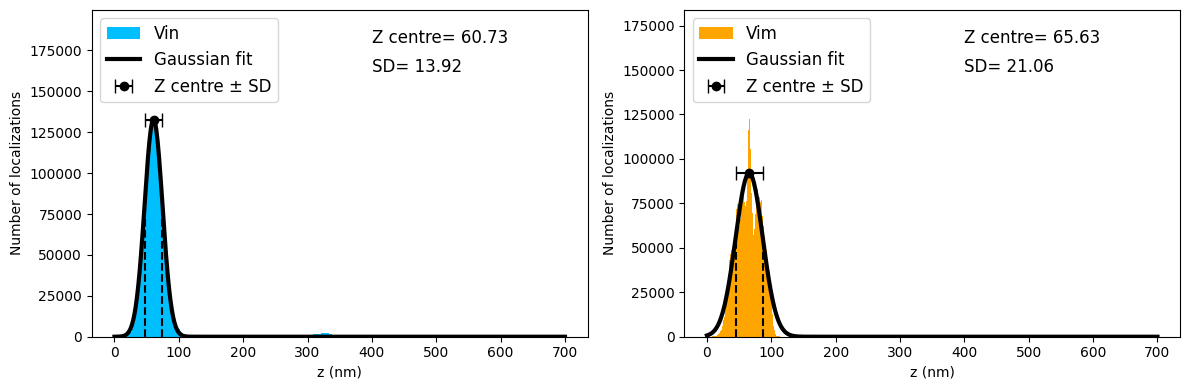

0.02766093391113465
0.019279907889134845
file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction


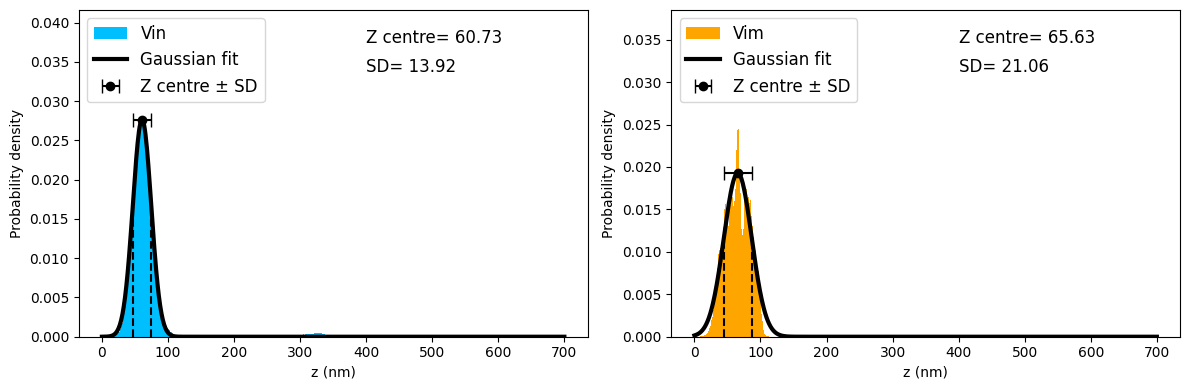

In [311]:
# Call the functions
plt.style.use('default')

# Define the number of bins such that it gives 1nm in between bins
his_bins = z_range_const

# Non-normalized histograms
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
# GF and plot for each ch for non-normalized histogram and save
popt_ch1 = fit_and_plot(ax1[0], filtered_data['UnwrappedZ'], his_bins, ch_col[0], ch_name[0][:3])
popt_ch2 = fit_and_plot(ax1[1], filtered_data2['UnwrappedZ'], his_bins, ch_col[1], ch_name[1][:3])

plt.tight_layout()
plt.savefig(parent_dir+ "//gaus_bar_2ch_final_gb.png")
print("file saved in the directory:", parent_dir)
plt.show()
plt.close(fig1) 

# Subplots for normalized histograms
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
# GF and plot for each ch for normalized histogram
popt_ch1_norm = fit_and_plot(ax2[0], filtered_data['UnwrappedZ'], his_bins, ch_col[0], ch_name[0][:3], normalize=True)
popt_ch2_norm = fit_and_plot(ax2[1], filtered_data2['UnwrappedZ'], his_bins, ch_col[1], ch_name[1][:3], normalize=True)

plt.tight_layout()

plt.savefig(parent_dir+ "//gaus_bar_2ch_final_normolised_GB.png")
print("file saved in the directory:", parent_dir)
plt.show()
plt.close(fig2)  

# Use the mask to remove GB

### Development was not strightforward, so ch separatelly


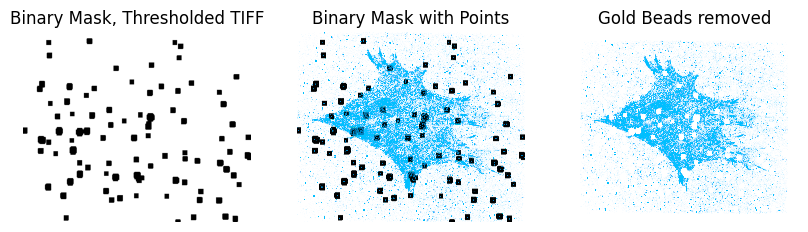

In [312]:
#ch1 
px = 133
# Invert the binary mask
binary_mask_invert = cv2.bitwise_not(binary_mask)
scaled_mask_invert= cv2.resize(binary_mask_invert, (image_gray.shape[1] * px, image_gray.shape[0] * px), interpolation=cv2.INTER_NEAREST)

# Convert (x, y) scatter plot data to mask coordinates
x = data_table_ch1_range['XPosition'].astype(int)
y = data_table_ch1_range['YPosition'].astype(int)

# Ensure coordinates do not go out of bounds after scaling
max_x = scaled_mask_invert.shape[1] - 1
max_y = scaled_mask_invert.shape[0] - 1

# Clip x and y to be within bounds
x = np.clip(x, 0, max_x)
y = np.clip(y, 0, max_y)

mask_values_invert = scaled_mask_invert[y, x]

# Apply the mask to filter points
filtered_x_invert = x[mask_values_invert == 255]
filtered_y_invert = y[mask_values_invert == 255]


# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(binary_mask_invert, cmap='gray')
axes[0].set_title('Binary Mask, Thresholded TIFF')
axes[0].axis('off')

axes[1].imshow(scaled_mask_invert, cmap='gray')
axes[1].scatter(x, y, s=0.05, label= ch_name[0][:3],marker='.', color= ch_col[0],edgecolors='none')
axes[1].set_title('Binary Mask with Points')
axes[1].axis('off')

axes[2].scatter(filtered_x_invert, filtered_y_invert, marker='.', s=0.05, color= ch_col[0], edgecolors='none')
axes[2].set_title('Gold Beads removed')
axes[2].axis('off')
axes[2].set_aspect('equal', 'box')
axes[2].invert_yaxis()
plt.savefig(parent_dir+ "//Gb_removed_process_ch1_withoutBeads.png",dpi=300)
#plt.legend()
plt.show()

/var/folders/_y/_0mkw2hs01z8ssfb0kcwd9k00000gn/T/ipykernel_4053/3990136394.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


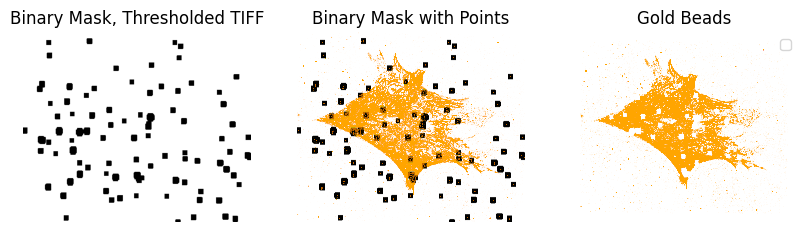

In [313]:
#Ch2
# Convert (x, y) scatter plot data to mask coordinates
x2 = data_table_ch2_range['XPosition'].astype(int)
y2 = data_table_ch2_range['YPosition'].astype(int)

# Ensure coordinates do not go out of bounds after scaling
max_x2 = scaled_mask_invert.shape[1] - 1
max_y2 = scaled_mask_invert.shape[0] - 1

# Clip x and y to be within bounds
x2 = np.clip(x2, 0, max_x2)
y2 = np.clip(y2, 0, max_y2)

mask_values2_invert = scaled_mask_invert[y2, x2]

# Apply the mask to filter points
filtered_x2_invert = x2[mask_values2_invert == 255]
filtered_y2_invert = y2[mask_values2_invert == 255]

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

axes[0].imshow(binary_mask_invert, cmap='gray')
axes[0].set_title('Binary Mask, Thresholded TIFF')
axes[0].axis('off')

axes[1].imshow(scaled_mask_invert, cmap='gray')
axes[1].scatter(x2, y2, s=0.05, label= ch_name[0][:3],marker='.', color= ch_col[1],edgecolors='none')
axes[1].set_title('Binary Mask with Points')
axes[1].axis('off')

axes[2].scatter(filtered_x2_invert, filtered_y2_invert, marker='.', s=0.1, color= ch_col[1], edgecolors='none')
axes[2].set_title('Gold Beads')
axes[2].axis('off')
axes[2].invert_yaxis()
axes[2].set_aspect('equal', 'box')
plt.savefig(parent_dir+ "//Gb_removed_process_ch2_withoutBeads.png",dpi=300)
plt.legend()
plt.show()

139362.17111759205
10581.690776636438
file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction


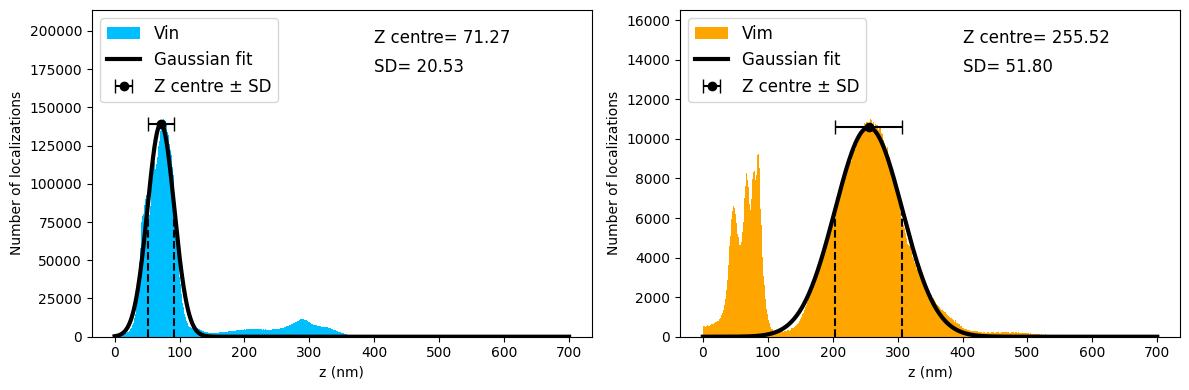

0.01675188893290005
0.00586652361641384
file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction


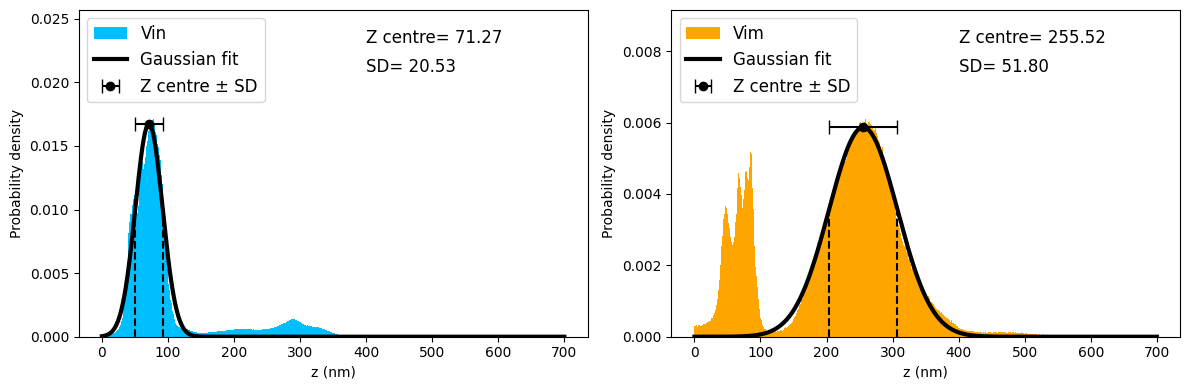

In [314]:
%matplotlib inline
# Call the functions GF and plot
plt.style.use('default')

# Define the number of bins such that it gives 1nm in between bins
his_bins = z_range_const

# Non-normalized histograms
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
# GF and plot for each ch for non-normalized histogram and save
popt_ch1 = fit_and_plot(ax1[0], filtered_data_invert['UnwrappedZ'], his_bins, ch_col[0], ch_name[0][:3])
popt_ch2 = fit_and_plot(ax1[1], filtered_data2_invert['UnwrappedZ'], his_bins, ch_col[1], ch_name[1][:3])

plt.tight_layout()
plt.savefig(parent_dir+ "//gaus_bar_2ch_final_gb_removed.png")
print("file saved in the directory:", parent_dir)
plt.show()
plt.close(fig1) 

# Subplots for normalized histograms
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
# GF and plot for each ch for normalized histogram
popt_ch1_norm = fit_and_plot(ax2[0], filtered_data_invert['UnwrappedZ'], his_bins, ch_col[0], ch_name[0][:3], normalize=True)
popt_ch2_norm = fit_and_plot(ax2[1], filtered_data2_invert['UnwrappedZ'], his_bins, ch_col[1], ch_name[1][:3], normalize=True)

plt.tight_layout()

plt.savefig(parent_dir+ "//gaus_bar_2ch_final_normolised_GB_removed.png")
print("file saved in the directory:", parent_dir)
plt.show()
plt.close(fig2)

# GB selecton manually



# START FROM HERE to select ROI

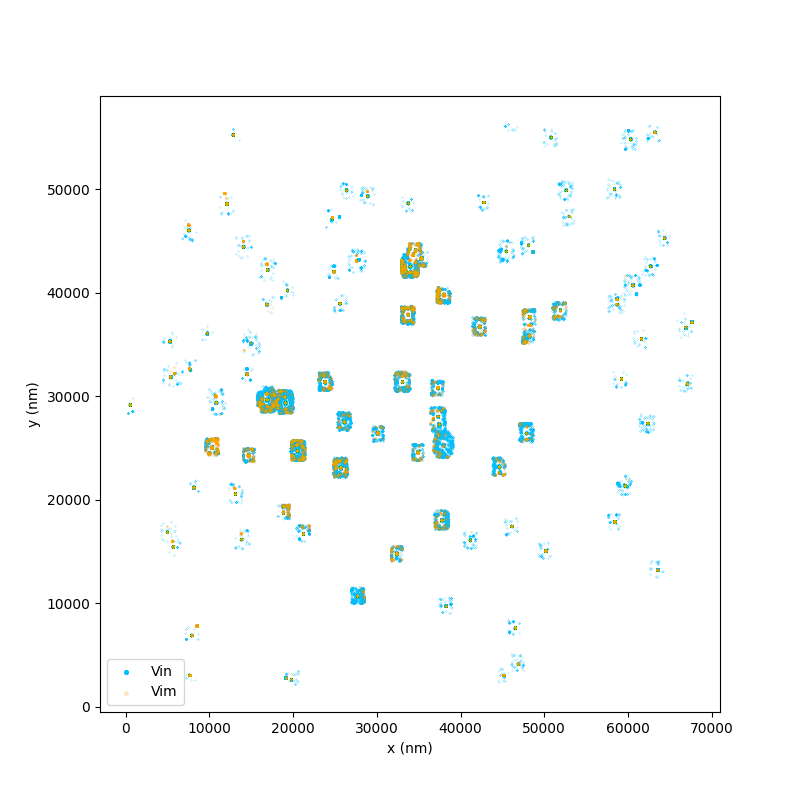

In [269]:
ch_name = ["Vin","Vim"]
ch_col = [c=ch_col[0],c=ch_col[1]]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path
plt.style.use('default')
%matplotlib widget

# Extract the data
# Assuming filtered_data is a pandas DataFrame
x1 = filtered_data['XPosition']#[::3]  # Take every 3rd element in the 'XPosition' column
y1 = filtered_data['YPosition']#[::3]  # Take every 3rd element in the 'YPosition' column
z1 = filtered_data['UnwrappedZ']#[::3]  # Take every 3rd element in the 'UnwrappedZ' column


x2 = filtered_data2['XPosition'][::3]  # Take every 3rd element in the 'XPosition' column
y2 = filtered_data2['YPosition'][::3]  # Take every 3rd element in the 'YPosition' column
z2 = filtered_data2['UnwrappedZ'][::3]  # Take every 3rd element in the 'UnwrappedZ' column


x1_zrange_initial = filtered_data['XPosition']
y1_zrange_initial = filtered_data['YPosition']
z1_zrange_initial = filtered_data['UnwrappedZ']

x2_zrange_initial = filtered_data2['XPosition']
y2_zrange_initial = filtered_data2['YPosition']
z2_zrange_initial = filtered_data2['UnwrappedZ']

# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x1, y1, s=0.1, label='Vin', marker='.', color=ch_col[0])
ax.scatter(x2, y2, s=0.1, label='Vim', marker='.', color=ch_col[1], alpha=0.2)

plt.xlabel(r'x (nm)')
plt.ylabel(r'y (nm)')

lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]

# Initialize variables to store selected points and their indices
selected_points_ch1 = []
selected_points_ch2 = []
selected_indices_ch1 = []
selected_indices_ch2 = []
selected_points_ch1_sliced = []
selected_points_ch2_sliced = []
polygon_nodes = []
polygon_patch = None

def onselect(verts):
    global selected_points_ch1, selected_points_ch2, selected_indices_ch1, selected_indices_ch2
    global selected_points_ch1_sliced, selected_points_ch2_sliced  # Declaring as global
    global polygon_nodes, polygon_patch

    path = Path(verts)
    
    # Check if each point is within the selected polygon for channel 1
    ind_ch1 = np.array([path.contains_point((xi, yi)) for xi, yi in zip(x1_zrange_initial, y1_zrange_initial)])
    selected_points_ch1 = [(xi, yi, zi) for xi, yi, zi in zip(x1_zrange_initial[ind_ch1], y1_zrange_initial[ind_ch1], z1_zrange_initial[ind_ch1])]
    selected_indices_ch1 = np.nonzero(ind_ch1)[0]  # Save indices of selected points
    
    # Check if each point is within the selected polygon for channel 2
    ind_ch2 = np.array([path.contains_point((xi, yi)) for xi, yi in zip(x2_zrange_initial, y2_zrange_initial)])
    selected_points_ch2 = [(xi, yi, zi) for xi, yi, zi in zip(x2_zrange_initial[ind_ch2], y2_zrange_initial[ind_ch2], z2_zrange_initial[ind_ch2])]
    selected_indices_ch2 = np.nonzero(ind_ch2)[0]  # Save indices of selected points

    selected_points_ch1_sliced = [(xi, yi, zi) for xi, yi, zi in zip(x1, y1, z1) if path.contains_point((xi, yi))]
    selected_points_ch2_sliced = [(xi, yi, zi) for xi, yi, zi in zip(x2, y2, z2) if path.contains_point((xi, yi))]
    
    polygon_nodes = verts
    if polygon_patch is not None:
        polygon_patch.remove()

    polygon_patch = plt.Polygon(verts, closed=True, fill=None, edgecolor='green', marker=".")
    ax.add_patch(polygon_patch)
    plt.draw()

def save_selected_points():
    ch1_df = pd.DataFrame(selected_points_ch1, columns=['XPosition', 'YPosition', 'UnwrappedZ'])
    ch2_df = pd.DataFrame(selected_points_ch2, columns=['XPosition', 'YPosition', 'UnwrappedZ'])

    # Optionally, save to CSV
    ch1_df.to_csv('selected_points_ch1.csv', index=False)
    ch2_df.to_csv('selected_points_ch2.csv', index=False)
    print("Selected points saved to 'selected_points_ch1.csv' and 'selected_points_ch2.csv'.")

# Create a PolygonSelector
polygon_selector = PolygonSelector(ax, onselect, useblit=True)

# Display the plot
plt.show()
#plt.close()

In [270]:
def create_new_folder_ROI(path, roi_folder_name):
    index = 0
    new_folder = os.path.join(path, f"{roi_folder_name}_{index}")

    while os.path.exists(new_folder):
        index += 1
        new_folder = os.path.join(path, f"{roi_folder_name}_{index}")
        
    print(new_folder, "was created")    
    os.makedirs(new_folder)
    return new_folder


folder_name = "GB"
path_to_ROI = create_new_folder_ROI(parent_dir, folder_name)
plt.close('all')

/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/cell_21/GB_14 was created


In [271]:
polygon_nodes_coord=polygon_nodes
data_poly = polygon_nodes_coord
roi_position = path_to_ROI.find('GB_')
    
# Extract the portion of the string up to and including 'ROI_1'
roi_name = path_to_ROI[roi_position :]
# Open a file in write mode
with open(path_to_ROI+ "//" +roi_name+ '.txt', 'w') as file:
    # Write each element of the list to the file
    for item in data_poly:
        file.write(f'{item}\n')

In [272]:
polygon_nodes_coord

[(20701.832350173452, 16384.29184090751),
 (21418.81589856055, 16384.29184090751),
 (21418.81589856055, 17157.263269478935),
 (20701.832350173452, 17157.263269478935)]

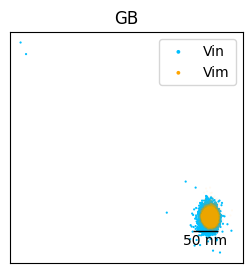

In [273]:

scalebar_length = 50  # length of the scale bar in data units
scalebar_label = '50 nm' 

data_table_ch1_range_ROI = pd.DataFrame(selected_points_ch1, columns=['XPosition', 'YPosition', 'UnwrappedZ'])
data_table_ch2_range_ROI = pd.DataFrame(selected_points_ch2, columns=['XPosition', 'YPosition', 'UnwrappedZ'])

%matplotlib inline
fig_roi, ax_roi = plt.subplots(figsize=(3, 3))

ax_roi.scatter(data_table_ch1_range_ROI ['XPosition'],data_table_ch1_range_ROI ['YPosition'], marker='.', color=ch_col[0], edgecolors='none', label=ch_name[0][:3], s=10)
ax_roi.scatter(data_table_ch2_range_ROI['XPosition'],data_table_ch2_range_ROI['YPosition'],alpha=0.05, marker='.', color=ch_col[1], edgecolors='none', label=ch_name[1][:3], s=10)
plt.xticks([])
plt.yticks([])
#plt.tight_layout()

# Create and add the scale bars to the plot
scalebar1 = AnchoredSizeBar(ax_roi.transData, scalebar_length, scalebar_label, loc='lower right', 
                            pad=1, color='black', frameon=False, size_vertical=0.02, 
                            fontproperties=FontProperties(size=10))
ax_roi.add_artist(scalebar1)
ax_roi.set_title(f'GB')
lgnd = ax_roi.legend(loc="best", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
lgnd.legend_handles[1]._alpha = [1]
fig_roi.savefig(path_to_ROI+ "//GB.png",dpi=300)

In [195]:
# Gaussian function
def gauss_f(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

# Function to fit data to a Gaussian and plot, i will call many times so put all together
def fit_and_plot(ax, data, bins, color, channel_name, normalize=False):
    n, bins, patches = ax.hist(data, bins=bins, color=color, label=channel_name, density=normalize)
    
    y_data_max = n.max()
    x_max_index = np.argmax(n)
    max_posit = bins[x_max_index] + np.diff(bins)[0] / 2  # Center of the bin
    initial_guess = [y_data_max, max_posit, np.std(data)]
    print('initial_guess',initial_guess)

    # Prepare the x data for the fit (bin centers)
    x_data = bins[:-1] + np.diff(bins) / 2

    # Fit the Gaussian model
    popt, _ = curve_fit(gauss_f, x_data, n, p0=initial_guess)

    # Generate model data for the fit curve
    x_model = np.linspace(0, z_range_const, z_range_const)
    y_model = gauss_f(x_model, *popt)

    # Plot the GF
    ax.plot(x_model, y_model, label='Gaus. fit', color="black", linewidth=3)
    ax.set_ylim(0, (y_data_max + 0.5 * y_data_max))

    # Add results to the graph as text
    results_z0 = "Z centre= {:.2f}".format(abs(popt[1]))
    results_sd = "SD= {:.2f}".format(abs(popt[2]))

    # Display the results on the plot
    label_coord_y = 1.4 * y_data_max
    ax.text(bins.max() - bins.max() /8, label_coord_y, results_z0, fontsize=9)
    ax.text(bins.max() - bins.max() /8, label_coord_y - 0.08 * label_coord_y, results_sd, fontsize=9)

    # Set labels and title
    ax.set(xlabel='z (nm)', ylabel='Probability density' if normalize else 'Number of localizations')
    #ax.set_title(channel_name)
    ax.legend(loc='upper left', fontsize=9)
    
    return popt, x_model, y_model  # Return the optimized parameters


initial_guess [2912.0, 71.5903055, 4.866856888060085]
initial_guess [7288.0, 65.66722707142857, 2.6931015012413155]
Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/cell_21/GB_14


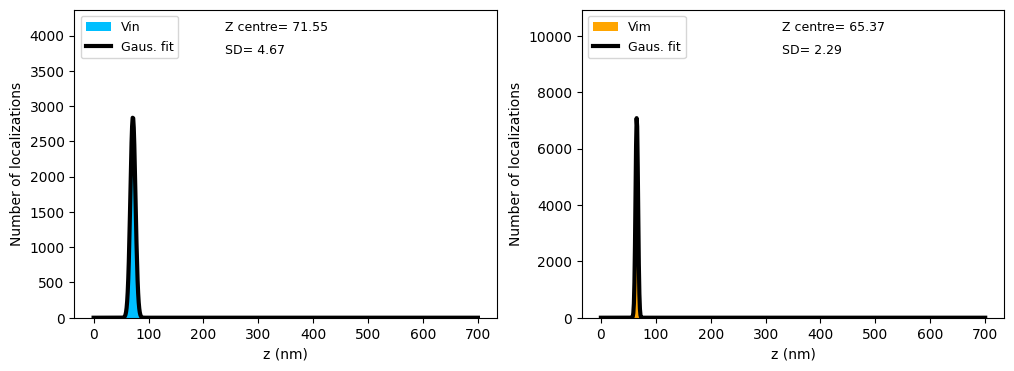

In [275]:
his_bins = z_range_const

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
# Perform Gaussian fit and plot for each channel for non-normalized histogram
popt_ch1 = fit_and_plot(ax1[0], data_table_ch1_range_ROI['UnwrappedZ'], his_bins, ch_col[0], ch_name[0][:3])
popt_ch2 = fit_and_plot(ax1[1], data_table_ch2_range_ROI['UnwrappedZ'], his_bins, ch_col[1], ch_name[1][:3])

A_opt_ch1_initROI, mu_opt_ch1_initROI, sig_opt_ch1_initROI = abs(popt_ch1[0])
A_opt_ch2_initROI, mu_opt_ch2_initROI, sig_opt_ch2_initROI = abs(popt_ch2[0])


lgnd.legend_handles[0]._sizes = [20] 
lgnd.legend_handles[1]._sizes = [20]

fig1.savefig(path_to_ROI+ "//Gaussian_fit_ROI_GB.png",dpi=300)
print('Results are saved to the folder:', path_to_ROI)
plt.show() 



In [276]:
#save in to the file, firstly couple of checks: if the file already exists, if such line already exists based on ROI_ind
z_center_ch1 = round(mu_opt_ch1_initROI, 2)
sd_ch1 = round(sig_opt_ch1_initROI,2) 
z_center_ch2 = round(mu_opt_ch2_initROI,2)
sd_ch2 = round(sig_opt_ch2_initROI,2) 

ROI_ind = os.path.basename(path_to_ROI) 
downsampling = 0  
peak_fit = 1  

results_file_path = os.path.join(parent_dir, "Gaussian_fit_results.txt")

# if the file already exists check
file_exists = os.path.isfile(results_file_path)

new_line = f"{ROI_ind},{z_center_ch1},{sd_ch1},{z_center_ch2},{sd_ch2},{downsampling},{peak_fit}\n"

lines = []

if file_exists:
    with open(results_file_path, 'r') as file:
        lines = file.readlines()
    updated = False
    for i, line in enumerate(lines):
        if line.startswith(ROI_ind + ","):
            lines[i] = new_line  # Replace the existing line
            updated = True
            break
    if not updated:
        lines.append(new_line)
else:
    lines.append("ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,1_or_2_peak_fit\n")
    lines.append(new_line)
with open(results_file_path, 'w') as file:
    file.writelines(lines)

print('Results are saved to the folder:', parent_dir)


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/cell_21


# Full image with ROI

In [277]:
%matplotlib inline

polygon_nodes_coord_um = [(x / 1000, y / 1000) for x, y in polygon_nodes_coord]
x_coords, y_coords = zip(*polygon_nodes_coord_um)
# Create a scatter plot
x1 = filtered_data['XPosition_mkm']
y1 = filtered_data['YPosition_mkm']

x2 = filtered_data2['XPosition_mkm']
y2 = filtered_data2['YPosition_mkm']



fig1, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x1, y1,  s=0.2, label= ch_name[0],marker='.', color= ch_col[0],edgecolors='none',alpha=1)
ax.scatter(x2, y2, s=0.05, label= ch_name[1],marker='.', color= ch_col[1],alpha=1,edgecolors='none')

plt.plot(x_coords, y_coords, color='orangered', linestyle='-', linewidth=1, marker='.', markersize=0)
plt.plot([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], color='orangered', linestyle='-', linewidth=1, label='ROI')

plt.xlabel(r'x ($\mu $m)')
plt.ylabel(r'y ($\mu $m)')

lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]

#save fig with ROI
fig1.savefig(path_to_ROI+ "//GB_on_the_cell_bothCh_onlyGB.png",dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//GB_on_the_cell_bothCh_onlyGB.png")
plt.close()

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/cell_21/GB_14//GB_on_the_cell_bothCh_onlyGB.png


In [278]:
%matplotlib inline

polygon_nodes_coord_um = [(x / 1000, y / 1000) for x, y in polygon_nodes_coord]
x_coords, y_coords = zip(*polygon_nodes_coord_um)
# Create a scatter plot
x1 = data_table_ch1_range['XPosition_mkm']
y1 = data_table_ch1_range['YPosition_mkm']

x2 = data_table_ch2_range['XPosition_mkm']
y2 = data_table_ch2_range['YPosition_mkm']



fig1, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x1, y1,  s=0.2, label= ch_name[0],marker='.', color= ch_col[0],edgecolors='none',alpha=1)
ax.scatter(x2, y2, s=0.05, label= ch_name[1],marker='.', color= ch_col[1],alpha=1,edgecolors='none')

plt.plot(x_coords, y_coords, color='orangered', linestyle='-', linewidth=1, marker='.', markersize=0)
plt.plot([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], color='orangered', linestyle='-', linewidth=1, label='ROI')

plt.xlabel(r'x ($\mu $m)')
plt.ylabel(r'y ($\mu $m)')

lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
#save fig with ROI
fig1.savefig(path_to_ROI+ "//GB_on_the_cell_bothCh.png",dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//GB_on_the_cell_bothCh.png")
plt.close()

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/cell_21/GB_14//GB_on_the_cell_bothCh.png


## Separate GB story ended

# All proceeded ROIs will be depicted on the XY plot ( over whole z range)

In [315]:
parent_dir= '/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/GB_correction'

In [316]:
plt.style.use('default')
x1 = data_table_ch1_range['XPosition_mkm']
y1 = data_table_ch1_range['YPosition_mkm']

x2 = data_table_ch2_range['XPosition_mkm']
y2 = data_table_ch2_range['YPosition_mkm']

# Plot the scatter plot as before
fig1, ax = plt.subplots(figsize=(8, 8))
scatter1 = ax.scatter(x1, y1, s=0.2, label=ch_name[0][:3], marker='.', color=ch_col[0], edgecolors='none')
scatter2 = ax.scatter(x2, y2, s=0.05, label=ch_name[1][:3], marker='.', color=ch_col[1], alpha=0.8, edgecolors='none')

# Define the folders to get data from
folders = [f"GB_{i}" for i in range(15)]

# Loop through each folder and plot the polygons
for folder in folders:
    file_path = os.path.join(parent_dir, folder, f"{folder}.txt")
    
    # Read the coordinates from the file
    polygon_coords = []
    with open(file_path, 'r') as file:
        for line in file:
            # Remove surrounding characters and split by comma
            coords = line.strip().strip('()').split(',')
            x, y = float(coords[0]), float(coords[1])
            polygon_coords.append([x/1000, y/1000])  # Store as a list of lists
    
    # Convert to numpy array
    polygon_coords = np.array(polygon_coords)
    
    if polygon_coords.shape[0] > 0:  # Ensure there's data to plot
        # Plot the polygon on the scatter plot
        ax.plot(polygon_coords[:, 0], polygon_coords[:, 1], linestyle='-', color='red', linewidth=1)
        # Close the polygon by connecting the last point to the first
        ax.plot([polygon_coords[-1, 0], polygon_coords[0, 0]], 
                [polygon_coords[-1, 1], polygon_coords[0, 1]], linestyle='-', color='red', linewidth=1)
        
        # Add the label (e.g., "GB_0") at the centroid of the polygon
        centroid_x = np.mean(polygon_coords[:, 0])+1
        centroid_y = np.mean(polygon_coords[:, 1])+1
        ax.text(centroid_x, centroid_y, folder[3:], fontsize=10, ha='center', va='center', color='black')

# Set plot labels and legend
ax.set_xlabel('X Position (µm)')
ax.set_ylabel('Y Position (µm)')

# Add the legend with scaled marker sizes
legend = ax.legend(loc="lower right", fontsize=10, scatterpoints=1)
for handle in legend.legend_handles:
    handle.set_sizes([30])  # Set marker size for each legend entry
# Show the plot
#plt.show()
fig1.savefig(parent_dir+ "//GBs_on_the_cell_bothCh_withGB_sum.png",dpi=300)
plt.close()

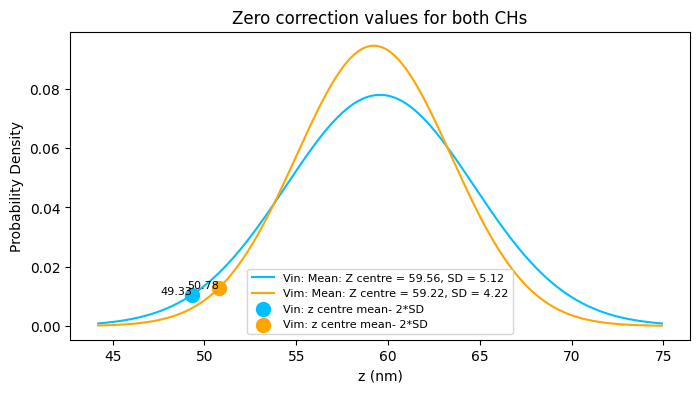

In [317]:
import json
output_file= "/Gaussian_fit_results.txt"
file_path= parent_dir+output_file
ch_name = ["Vinculin","Vimentin"]
ch_col = ["deepskyblue","orange"]
df = pd.read_csv(file_path)

# Calculate the mean values for each channel
mean_z_center_ch1 = df['z_center_ch1'].mean()
mean_z_center_ch2 = df['z_center_ch2'].mean()

# Calculate the mean values for the standard deviations
mean_sd_ch1 = df['sd_ch1'].mean()
mean_sd_ch2 = df['sd_ch2'].mean()

# Generate a range of x values for the plot
x_values = np.linspace(min(mean_z_center_ch1 - 3*mean_sd_ch1, mean_z_center_ch2 - 3*mean_sd_ch2),
                       max(mean_z_center_ch1 + 3*mean_sd_ch1, mean_z_center_ch2 + 3*mean_sd_ch2), 1000)

# Calculate the Gaussian distribution for each channel
gaussian_ch1 = (1 / (mean_sd_ch1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean_z_center_ch1) / mean_sd_ch1) ** 2)
gaussian_ch2 = (1 / (mean_sd_ch2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean_z_center_ch2) / mean_sd_ch2) ** 2)

# Calculate the position for z_center - 2*SD for both channels
z_center_minus_2sd_ch1 = mean_z_center_ch1 - 2 * mean_sd_ch1
z_center_minus_2sd_ch2 = mean_z_center_ch2 - 2 * mean_sd_ch2

# Calculate the corresponding y values on the Gaussian curve for these points
gaussian_y_ch1 = (1 / (mean_sd_ch1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((z_center_minus_2sd_ch1 - mean_z_center_ch1) / mean_sd_ch1) ** 2)
gaussian_y_ch2 = (1 / (mean_sd_ch2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((z_center_minus_2sd_ch2 - mean_z_center_ch2) / mean_sd_ch2) ** 2)

# Plot the Gaussian curves
plt.figure(figsize=(8, 4))
plt.plot(x_values, gaussian_ch1, label=f'{ch_name[0][:3]}: Mean: Z centre = {mean_z_center_ch1:.2f}, SD = {mean_sd_ch1:.2f}', c=ch_col[0])
plt.plot(x_values, gaussian_ch2, label=f'{ch_name[1][:3]}: Mean: Z centre = {mean_z_center_ch2:.2f}, SD = {mean_sd_ch2:.2f}', c=ch_col[1])

# Add the z_center - 2*SD points
plt.scatter([z_center_minus_2sd_ch1], [gaussian_y_ch1], color=ch_col[0], s=100, label=f'{ch_name[0][:3]}: z centre mean- 2*SD')
plt.scatter([z_center_minus_2sd_ch2], [gaussian_y_ch2], color=ch_col[1], s=100, label=f'{ch_name[1][:3]}: z centre mean- 2*SD')

# Annotate the points with their values
plt.text(z_center_minus_2sd_ch1, gaussian_y_ch1, f'{z_center_minus_2sd_ch1:.2f}',color="black", fontsize=8, ha='right')
plt.text(z_center_minus_2sd_ch2, gaussian_y_ch2, f'{z_center_minus_2sd_ch2:.2f}', color='black', fontsize=8, ha='right')

# Add labels and title
plt.xlabel('z (nm)')
plt.ylabel('Probability Density')
plt.title('Zero correction values for both CHs')
plt.legend(fontsize=8)
plt.savefig(parent_dir+ "//CorrectionZ_values.png",dpi=300)
# Show the plot
plt.show()


# To correct Z:  UnwrappedZ- mean-2SD, that will be zero correction
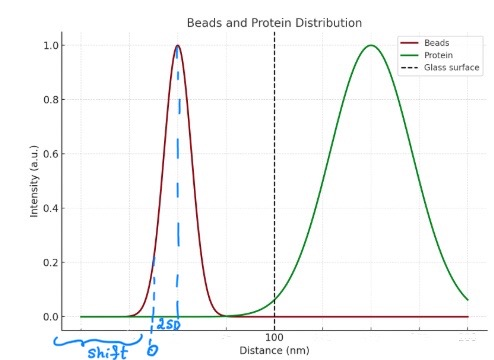

In [318]:
parent_dir= '/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21'

In [320]:
#only GB
filtered_data["UnwrappedZ_corrected"]=filtered_data["UnwrappedZ"]-z_center_minus_2sd_ch1
filtered_data2["UnwrappedZ_corrected"]=filtered_data2["UnwrappedZ"]-z_center_minus_2sd_ch2
#without GB
filtered_data_invert["UnwrappedZ_corrected"]=filtered_data_invert["UnwrappedZ"]-z_center_minus_2sd_ch1
filtered_data2_invert["UnwrappedZ_corrected"]=filtered_data2_invert["UnwrappedZ"]-z_center_minus_2sd_ch2

/var/folders/_y/_0mkw2hs01z8ssfb0kcwd9k00000gn/T/ipykernel_4053/514383522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["UnwrappedZ_corrected"]=filtered_data["UnwrappedZ"]-z_center_minus_2sd_ch1
/var/folders/_y/_0mkw2hs01z8ssfb0kcwd9k00000gn/T/ipykernel_4053/514383522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data2["UnwrappedZ_corrected"]=filtered_data2["UnwrappedZ"]-z_center_minus_2sd_ch2


# Let's save data with removed GB for further prosessing

In [321]:
# Save the filtered DataFrame to a fileOnly GB
output_txt_path = os.path.join(parent_dir, 'onlyGb_Zcorrected_ch1_cellx21.csv')
filtered_data.to_csv(output_txt_path, index=False)
output_txt_path = os.path.join(parent_dir, 'onlyGb_Zcorrected_ch2_cellx21.csv')
filtered_data2.to_csv(output_txt_path, index=False)

In [322]:
# Save the filtered DataFrame to a file without GB
output_txt_path = os.path.join(parent_dir, 'withoutGb_Zcorrected_ch1_cellx21.csv')
filtered_data_invert.to_csv(output_txt_path, index=False)
output_txt_path = os.path.join(parent_dir, 'withoutGb_Zcorrected_ch2_cellx21.csv')
filtered_data2_invert.to_csv(output_txt_path, index=False)

# Load data if it was saved before

In [323]:
filtered_data_invert_path = os.path.join(parent_dir, 'withoutGb_Zcorrected_ch1_cellx21.csv')
filtered_data2_invert_path = os.path.join(parent_dir, 'withoutGb_Zcorrected_ch2_cellx21.csv')
# Load the CSV file
filtered_data_invert = pd.read_csv(filtered_data_invert_path)
filtered_data2_invert = pd.read_csv(filtered_data2_invert_path)

In [17]:
ch_name = ["Vinculin","Vimentin"]
ch_col = ['deepskyblue',"orange"]


In [324]:
ROI_coordinate_parent_dir="/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_coordinates/"

## To create structures for files with output data
2 different structures for further datafiles output  will be created, first data corrisponds to whole cell
Overall whole program will create 3 output data 2 in the main file folder (parent_dir) and one with coordinates in ROI folder

In [363]:
from astropy.table import Table
data_output = []
data_output =  [{'ROI_ind':"", 'z_center_ch1':0.0 , 'sd_ch1':0.0, 'z_center_ch2':0.0 , 'sd_ch2':0.0, 'downsampling':0,
               '1_or_2_peak_fit':1}]

table_output_ROI = Table(rows=data_output)
print(table_output_ROI)

ROI_ind z_center_ch1 sd_ch1 z_center_ch2 sd_ch2 downsampling 1_or_2_peak_fit
------- ------------ ------ ------------ ------ ------------ ---------------
                 0.0    0.0          0.0    0.0            0               1


In [364]:
#for 2 peaks fitting data
data_output_2peak=[]
data_output_2peak =  [{'ROI_ind':"name", 'z0_ch1_peak1':0.0 , 'sd_ch1_peak1':0.0, 'z0_ch1_peak2':0.0 , 'sd_ch1_peak2':0.0, 'z_0_ch2':0.0 , 'sd_ch2':0.0, 'downsampling':0,
               '1_or_2_peak_fit':2}]

table_output_ROI_2peak = Table(rows=data_output_2peak)
print(table_output_ROI_2peak)

ROI_ind z0_ch1_peak1 sd_ch1_peak1 ... sd_ch2 downsampling 1_or_2_peak_fit
------- ------------ ------------ ... ------ ------------ ---------------
   name          0.0          0.0 ...    0.0            0               2


In [13]:
#come to start with new ROI

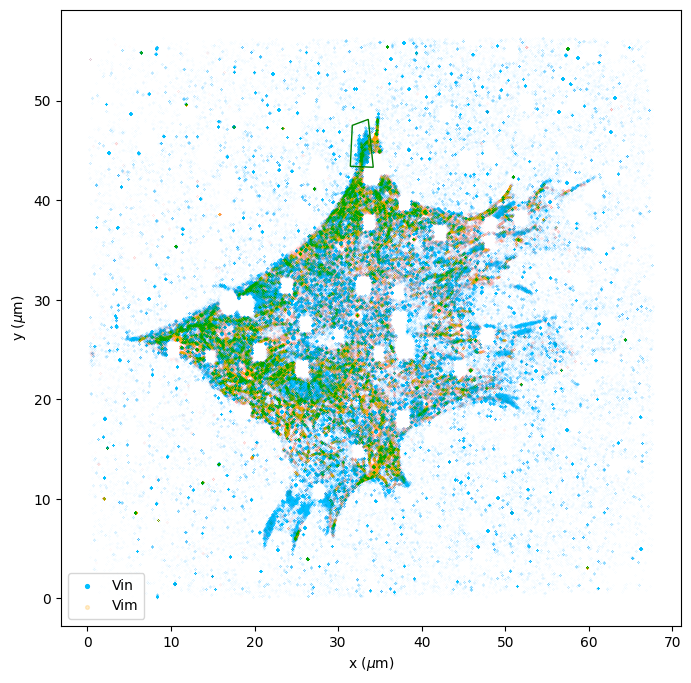

In [325]:
file_path = ROI_coordinate_parent_dir+'//ROI_16.txt'

plt.style.use('default')

# Extract the data
x1 = filtered_data_invert['XPosition_mkm']
y1 = filtered_data_invert['YPosition_mkm']
x2 = filtered_data2_invert['XPosition_mkm']
y2 = filtered_data2_invert['YPosition_mkm']

# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x1, y1, s=0.001, label=ch_name[0][:3], marker='.', color=ch_col[0])
ax.scatter(x2, y2, s=0.001, label=ch_name[1][:3], marker='.', color=ch_col[1], alpha=0.2)

plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')

lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]

# Read the coordinates from the file (path_to_your_file.txt)
coordinates = []  # Placeholder for coordinates read from file

with open(file_path, 'r') as file:
    for line in file:
        stripped_line = line.strip("()\n")
        x, y = stripped_line.split(", ")
        coordinates.append((float(x), float(y)))

# Create a Path object from the coordinates
polygon_path = Path(coordinates)

# Function to select points within the polygon
def select_points_within_polygon(x, y, path):
    return [(xi, yi) for xi, yi in zip(x, y) if path.contains_point((xi, yi))]

# Select points for channel 1 and 2
selected_points_ch1 = select_points_within_polygon(x1, y1, polygon_path)
selected_points_ch2 = select_points_within_polygon(x2, y2, polygon_path)

# Plotting the polygon (optional for visualization)
polygon_patch = plt.Polygon(coordinates, closed=True, fill=None, edgecolor='green')
ax.add_patch(polygon_patch)

plt.show()
polygon_nodes = coordinates

In [326]:
# Function to select points within the polygon and return selected points along with their indices
x1_zrange_initial = x1
y1_zrange_initial = y1

x2_zrange_initial = x2
y2_zrange_initial = y2

def select_points_and_indices_within_polygon(x, y, path):
    selected_points = []
    selected_indices = []
    for index, (xi, yi) in enumerate(zip(x, y)):
        if path.contains_point((xi, yi)):
            selected_points.append((xi, yi))
            selected_indices.append(index)
    return selected_points, selected_indices

selected_points_ch1, selected_indices_ch1= select_points_and_indices_within_polygon(x1_zrange_initial, y1_zrange_initial, polygon_path)
selected_points_ch2, selected_indices_ch2 = select_points_and_indices_within_polygon(x2_zrange_initial, y2_zrange_initial, polygon_path)




In [327]:

folder_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract "ROI_0" from the file path

# Construct the full directory path
folder_path = os.path.join(parent_dir, folder_name)

# Check if the folder exists, and create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

# Now proceed with any operations inside this folder
path_to_ROI=folder_path

Folder '/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16' created.


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//ROI_on_the_cell_bothCh_only_backup.png


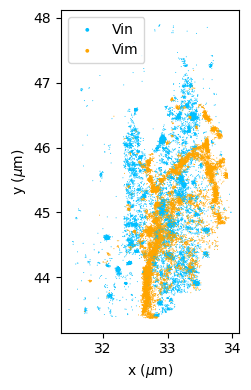

In [328]:
%matplotlib inline

d=2
fig1, ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', 'box')
plt.scatter(*zip(*selected_points_ch1), marker='.', color=ch_col[0], edgecolors='none', label=ch_name[0][:3], s=d)
plt.scatter(*zip(*selected_points_ch2), marker='.', color=ch_col[1], edgecolors='none', label=ch_name[1][:3], s=d)

plt.xlabel(r'x ($\mu $m)')
plt.ylabel(r'y ($\mu $m)')

lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
plt.tight_layout()
#save fig with ROI
fig1.savefig(path_to_ROI+ "//ROI_on_the_cell_bothCh_only_backup.png",dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//ROI_on_the_cell_bothCh_only_backup.png")


#

plt.show()
plt.close()

In [329]:
# Function to select points within the polygon and return selected points along with their indices
x1_zrange_initial = filtered_data_invert['XPosition_mkm']
y1_zrange_initial = filtered_data_invert['YPosition_mkm']

x2_zrange_initial = filtered_data2_invert['XPosition_mkm']
y2_zrange_initial = filtered_data2_invert['YPosition_mkm']

def select_points_and_indices_within_polygon(x, y, path):
    selected_points = []
    selected_indices = []
    for index, (xi, yi) in enumerate(zip(x, y)):
        if path.contains_point((xi, yi)):
            selected_points.append((xi, yi))
            selected_indices.append(index)
    return selected_points, selected_indices

selected_points_ch1, selected_indices_ch1= select_points_and_indices_within_polygon(x1_zrange_initial, y1_zrange_initial, polygon_path)
selected_points_ch2, selected_indices_ch2 = select_points_and_indices_within_polygon(x2_zrange_initial, y2_zrange_initial, polygon_path)




In [330]:
# Ensure the DataFrame has a default integer index, there was some issues so extra checkes
filtered_data_invert = filtered_data_invert.reset_index(drop=True)
filtered_data2_invert = filtered_data2_invert.reset_index(drop=True)

# Use .iloc to select rows based on the indices
data_table_ch1_range_ROI = filtered_data_invert.iloc[selected_indices_ch1]
data_table_ch2_range_ROI = filtered_data2_invert.iloc[selected_indices_ch2]



In [331]:
#columns = ["UnwrappedZ", "XPosition", "YPosition", "LabelSet", "XPosition_mkm", "YPosition_mkm", "UnwrappedZ_corrected"]
data_table_ch1_range_ROI = pd.DataFrame(data_table_ch1_range_ROI)#, columns=columns)

# Save the DataFrame to a text file
output_file = "ch1_range_ROI.txt"
folder_path_data = os.path.join(path_to_ROI, output_file)
data_table_ch1_range_ROI.to_csv(folder_path_data, sep='\t', index=False)


# Save the DataFrame to a text file
output_file = "ch2_range_ROI.txt"
folder_path_data = os.path.join(path_to_ROI, output_file)
data_table_ch2_range_ROI.to_csv(folder_path_data, sep='\t', index=False)



print(f"Data saved to {output_file}")

Data saved to ch2_range_ROI.txt


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//ROI_on_the_cell_bothCh_only.png


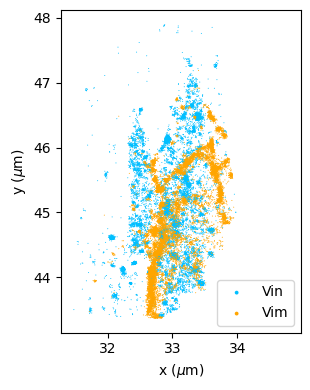

In [332]:
%matplotlib inline
# this is here as last check for new data file there were issues with data selection 

m=2
fig1, ax = plt.subplots(figsize=(4,4))

plt.scatter(data_table_ch1_range_ROI['XPosition_mkm'],data_table_ch1_range_ROI['YPosition_mkm'], marker='.', color=ch_col[0], edgecolors='none', label=ch_name[0][:3], s=m)
plt.scatter(data_table_ch2_range_ROI['XPosition_mkm'],data_table_ch2_range_ROI['YPosition_mkm'],marker='.', color=ch_col[1], edgecolors='none', label=ch_name[1][:3], s=m)

plt.xlabel(r'x ($\mu $m)')
plt.ylabel(r'y ($\mu $m)')
ax.set_aspect('equal', 'box')
ax.set_xlim(min(data_table_ch1_range_ROI['XPosition_mkm'])-0.2, max(data_table_ch1_range_ROI['XPosition_mkm']+1))
plt.tight_layout()
lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
#save fig with ROI
fig1.savefig(path_to_ROI+ "//ROI_on_the_cell_bothCh_only.png",dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//ROI_on_the_cell_bothCh_only.png")


plt.show()
plt.close()


In [333]:
def fit_and_plot(ax, data, bins, color, channel_name, normalize=False):
    n, bins, patches = ax.hist(data, bins=bins, color=color, label=channel_name, density=normalize)
    
    # Initial guess for the Gaussian parameters
    y_data_max = n.max()
    x_max_index = np.argmax(n)
    max_posit = bins[x_max_index] + np.diff(bins)[0] / 2  # Center of the bin
    initial_guess = [y_data_max, max_posit, np.std(data)]

    # Prepare the x data for the fit (bin centers)
    x_data = bins[:-1] + np.diff(bins) / 2
    popt, _ = curve_fit(gauss_f, x_data, n, p0=initial_guess)

    # Generate model data for the fit curve
    x_model = np.linspace(0, z_range_const, z_range_const)
    y_model = gauss_f(x_model, *popt)

    # Plot the Gaussian fit
    ax.plot(x_model, y_model, label='Gaussian fit', color="black", linewidth=3)

    # Display z-center as a point with SD as error bars
    y_center = gauss_f(popt[1], *popt)
    ax.errorbar(popt[1], y_center, xerr=popt[2], fmt='o', color='black', capsize=5, label='Z centre ± SD')
    ax.set_ylim(0, (y_data_max + 0.5 * y_data_max))
    ax.set_xlim(0, z_range_const)
    # Drawing z-center ± SD lines to the height where SD on the fit
    sd_pos = popt[1] + popt[2]  # z-center + SD
    sd_neg = popt[1] - popt[2]  # z-center - SD
    y_sd_pos = gauss_f(sd_pos, *popt)
    y_sd_neg = gauss_f(sd_neg, *popt)

    # Draw vertical lines for z-center ± SD
    ax.vlines(sd_pos, 0, y_sd_pos, colors='black', linestyles='dashed')
    ax.vlines(sd_neg, 0, y_sd_neg, colors='black', linestyles='dashed')

    # Add results to the graph as text
    results_z0 = "Z centre= {:.2f}".format(popt[1])
    results_sd = "SD= {:.2f}".format(popt[2])
    label_coord_y = 1.35 * y_data_max
    ax.text(x_model.max() - 300, label_coord_y, results_z0, fontsize=12)
    ax.text(x_model.max() - 300, label_coord_y - 0.1 * label_coord_y, results_sd, fontsize=12)
    ax.set(xlabel='z (nm)', ylabel='Probability density' if normalize else 'Number of localizations')
    ax.legend(loc='upper left', fontsize=12)

    # Return fitted parameters and model data
    return popt, x_model, y_model


In [334]:
# Define the Gaussian function
def gauss_f(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

In [335]:
plt.style.use('default')
his_bins = z_range_const

#save fig with ROI
#plot_to_save.savefig(path_to_ROI+ "//ROI_on_the_cell.png",dpi=300)
#save data from poligone selection

polygon_nodes_coord = polygon_nodes
    
    
# save ROI poligone coordinates into file
data_poly = polygon_nodes_coord
# Find the position of 'ROI_1' in the string
roi_position = path_to_ROI.find('ROI')
    
# Extract the portion of the string up to and including 'ROI_1'
roi_name = path_to_ROI[roi_position :]
    
# Open a file in write mode
with open(path_to_ROI+ "//" +roi_name+ '.txt', 'w') as file:
    # Write each element of the list to the file
    for item in data_poly:
        file.write(f'{item}\n')

file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


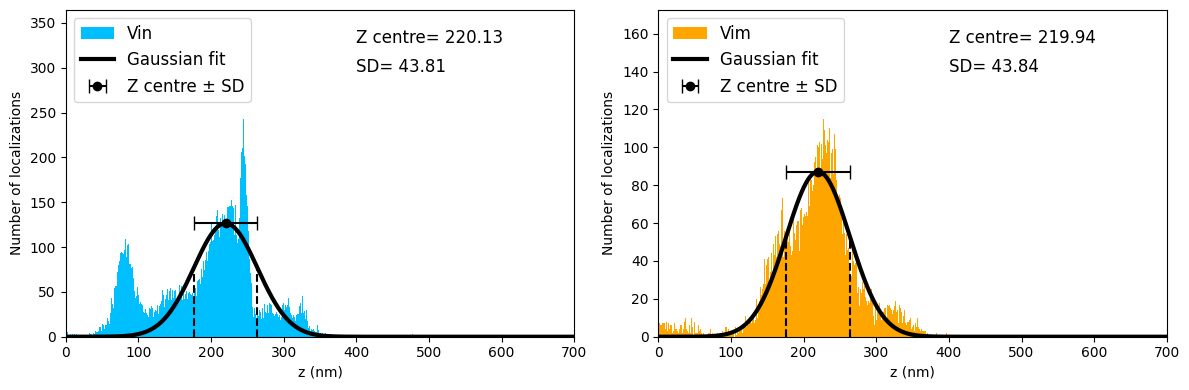

file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


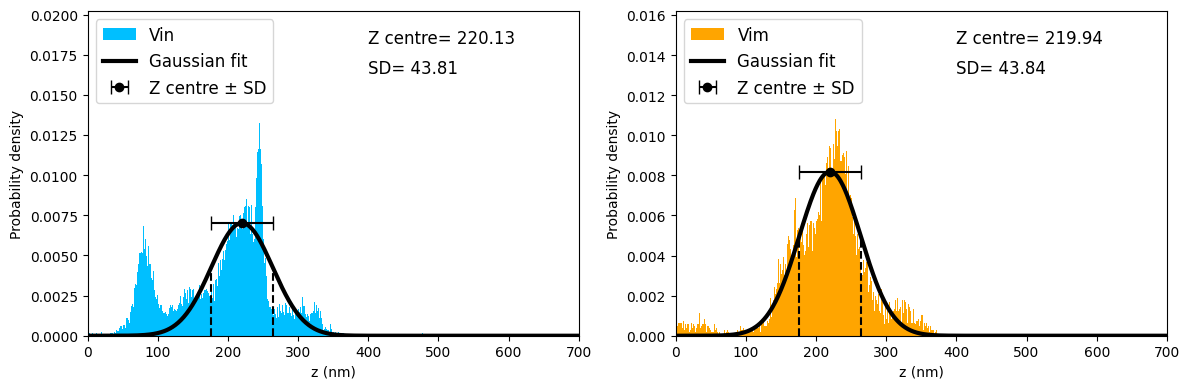

In [336]:
# Call the functions
%matplotlib inline
plt.style.use('default')

# Define the number of bins such that it gives 1nm in between bins
his_bins = z_range_const

# Non-normalized histograms
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
# GF and plot for each ch for non-normalized histogram and save
popt_ch1 = fit_and_plot(ax1[0], data_table_ch1_range_ROI['UnwrappedZ_corrected'], his_bins, ch_col[0], ch_name[0][:3])
popt_ch2 = fit_and_plot(ax1[1], data_table_ch2_range_ROI['UnwrappedZ_corrected'], his_bins, ch_col[1], ch_name[1][:3])

plt.tight_layout()
plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_ROI.png")
print("file saved in the directory:", path_to_ROI)
plt.show()
plt.close(fig1) 

# Subplots for normalized histograms
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
# GF and plot for each ch for normalized histogram
popt_ch1_norm = fit_and_plot(ax2[0], data_table_ch1_range_ROI['UnwrappedZ_corrected'], his_bins, ch_col[0] , ch_name[0][:3], normalize=True)
popt_ch2_norm = fit_and_plot(ax2[1], data_table_ch2_range_ROI['UnwrappedZ_corrected'], his_bins, ch_col[1], ch_name[1][:3], normalize=True)
plt.tight_layout()

plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_ROI.png")
print("file saved in the directory:", path_to_ROI)
plt.show()
plt.close(fig2)  

In [337]:
from IPython.display import clear_output
from ipywidgets import widgets
def button_VIM_count_NOT_enough(_):
    global VIM_count
    VIM_count = 0 #no downsampling of the "noise" range needed
    with output:
        clear_output(wait=True)
        print("Not enough counts in VIM chanel")
        print("VIM_count = 0")



# Function to handle the action for Button 2
def button_VIM_count_enough(_):
    global VIM_count
    VIM_count = 1
    with output:
        clear_output(wait=True)
        print("Enough counts in VIM chanel")
        print("VIM_count = 1")

# Create buttons
not_enougth_VIM = widgets.Button(description="Not enough ")
enougth_VIM = widgets.Button(description="Enough")

# Attach button click events to functions
not_enougth_VIM.on_click(button_VIM_count_NOT_enough)
enougth_VIM.on_click(button_VIM_count_enough)

# Create output area to display results
output = widgets.Output()

# Display buttons and output area
display(not_enougth_VIM, enougth_VIM, output)


Button(description='Not enough ', style=ButtonStyle())

Button(description='Enough', style=ButtonStyle())

Output()

In [338]:
VIM_count = 1


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


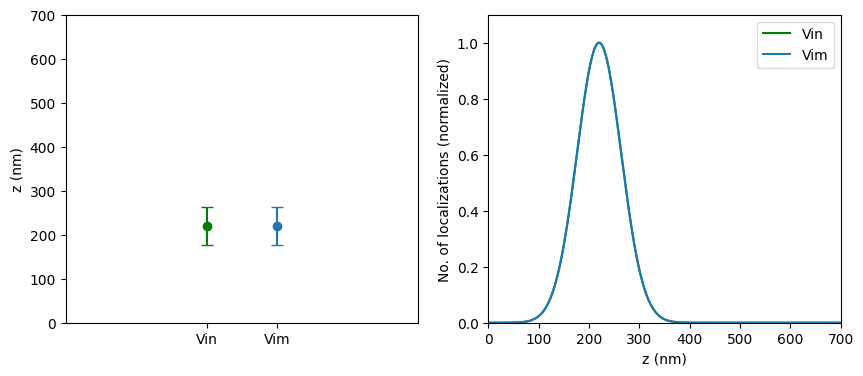

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


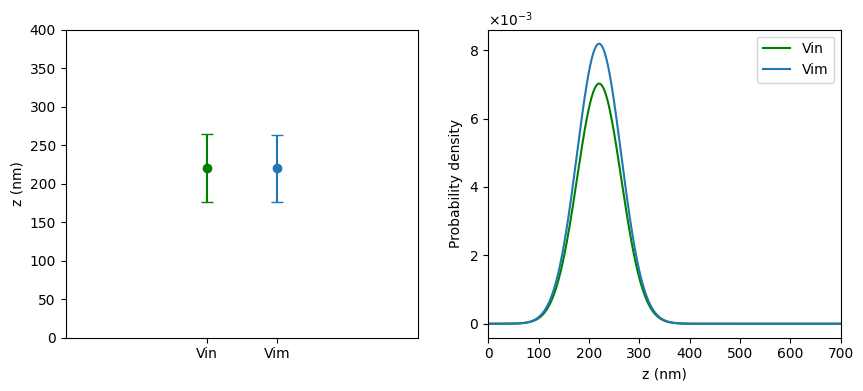

In [339]:
from matplotlib.ticker import ScalarFormatter
A_opt_ch1, mu_opt_ch1, sig_opt_ch1 = popt_ch1[0]
A_opt_ch2, mu_opt_ch2, sig_opt_ch2 = popt_ch2[0]
x_model_ch1 = popt_ch1_norm[1]
y_model_ch1 = popt_ch1_norm[2]

x_model_ch2 = popt_ch2_norm[1]
y_model_ch2 = popt_ch2_norm[2]

print()
fig, ax = plt.subplots(1,2,figsize=(10,4))
    
ax[0].errorbar(ch_name[0][:3], mu_opt_ch1, abs(sig_opt_ch1), linestyle='None', marker='o',color="green",capsize=4,
                   label= ch_name[0][:3])

ax[1].plot(x_model_ch1, y_model_ch1/max(y_model_ch1), label=(ch_name[0][:3]),color="green")

if VIM_count == 1:
    ax[0].errorbar(ch_name[1][:3], mu_opt_ch2, abs(sig_opt_ch2), linestyle='None', marker='o',capsize=4,
                  label= ch_name[1][:3])
    ax[1].plot(x_model_ch2, y_model_ch2/max(y_model_ch2), label=(ch_name[1][:3]))
    
#Set up graph1 
ax[0].set_ylabel('z (nm)')
#ax[0].legend()
ax[0].set_xlim(-2,3)
ax[0].set_ylim(0,z_range_const)
#ax[0].legend(loc="upper left", scatterpoints=1, fontsize=8)
    
#Set up graph2
ax[1].set_xlabel('z (nm)')
ax[1].set_ylabel('No. of localizations (normalized)')
ax[1].legend()
ax[1].set_xlim(0,z_range_const)
ax[1].set_ylim(0,1.1)

#Save a plot panel
plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_max_to_be_1.png")
print('Results are saved to the folder:', path_to_ROI)
plt.show()

#####################################


A_opt_ch1, mu_opt_ch1, sig_opt_ch1 = popt_ch1_norm[0]
A_opt_ch2, mu_opt_ch2, sig_opt_ch2 = popt_ch2_norm[0]
x_model_ch1 = popt_ch1_norm[1]
y_model_ch1 = popt_ch1_norm[2]

x_model_ch2 = popt_ch2_norm[1]
y_model_ch2 = popt_ch2_norm[2]


fig, ax = plt.subplots(1,2,figsize=(10,4))
    
ax[0].errorbar(ch_name[0][:3], mu_opt_ch1, abs(sig_opt_ch1), linestyle='None', marker='o',color="green",capsize=4,
                   label= ch_name[0][:3])

ax[1].plot(x_model_ch1, y_model_ch1, label=(ch_name[0][:3]),color="green")

if VIM_count == 1:
    ax[0].errorbar(ch_name[1][:3], mu_opt_ch2, abs(sig_opt_ch2), linestyle='None', marker='o',capsize=4,
                  label= ch_name[1][:3])
    
    ax[1].plot(x_model_ch2, y_model_ch2, label=(ch_name[1][:3]))
    
#Set up graph1 
ax[0].set_ylabel('z (nm)')
#ax[0].legend()
ax[0].set_xlim(-2,3)
ax[0].set_ylim(0,400)
#ax[0].legend(loc="upper left", scatterpoints=1, fontsize=8)
    
#Set up graph2
ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].set_xlabel('z (nm)')
ax[1].set_ylabel('Probability density')
ax[1].legend()
ax[1].set_xlim(0,z_range_const)
#ax[1].set_ylim(0,1.1)
plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_to_probabilityDensity.png")
print('Results are saved to the folder:', path_to_ROI)
plt.show()

 ## Data downsampling in the ramge 0-100 when GB in ROI

In [340]:
downsample_mode=0

In [341]:
from IPython.display import clear_output
from ipywidgets import widgets
def button_action_gauss(_):
    global downsample_mode
    downsample_mode = 0 #no downsampling of the "noise" range needed
    with output:
        clear_output(wait=True)
        print("No downsampling needed")
        print("downsample_mode = 0")



# Function to handle the action for Button 2
def button_action_doub_gauss(_):
    global downsample_mode
    downsample_mode = 1
    with output:
        clear_output(wait=True)
        print("Downsampling is needed")
        print("downsample_mode = 1")

print("Downsampling is needed if VIM mean+-2Sd containes mostly noise" )
# Create buttons
gauss = widgets.Button(description="No downsampling")
double_gauss = widgets.Button(description="Downsampling")

# Attach button click events to functions
gauss.on_click(button_action_gauss)
double_gauss.on_click(button_action_doub_gauss)

# Create output area to display results
output = widgets.Output()

# Display buttons and output area
display(gauss, double_gauss, output)


Downsampling is needed if VIM mean+-2Sd containes mostly noise


Button(description='No downsampling', style=ButtonStyle())

Button(description='Downsampling', style=ButtonStyle())

Output()

In [346]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt

def data_downsampling(ch1_data, ch2_data, z_min, z_max, downsampling_factor_ch1, downsampling_factor_ch2, save_figure_path):
    # Select data within the specified 'z' range for each channel.
    selected_data_ch1 = ch1_data[(ch1_data['UnwrappedZ_corrected'] >= z_min) & (ch1_data['UnwrappedZ_corrected'] <= z_max)]
    selected_data_ch2 = ch2_data[(ch2_data['UnwrappedZ_corrected'] >= z_min) & (ch2_data['UnwrappedZ_corrected'] <= z_max)]

    # Calculate the mean and standard deviation for the Gaussian distribution.
    mean_ch1 = selected_data_ch1['UnwrappedZ_corrected'].mean()
    std_ch1 = (z_max - z_min) / 4  # A heuristic for spread; adjust if needed.
    mean_ch2 = selected_data_ch2['UnwrappedZ_corrected'].mean()
    std_ch2 = (z_max - z_min) / 4  # A heuristic for spread; adjust if needed.

    # Calculate weights for Gaussian probability within the range.
    weights_ch1 = np.exp(-0.5 * ((selected_data_ch1['UnwrappedZ_corrected'] - mean_ch1) / std_ch1) ** 2)
    weights_ch2 = np.exp(-0.5 * ((selected_data_ch2['UnwrappedZ_corrected'] - mean_ch2) / std_ch2) ** 2)

    # Normalize weights to sum to 1.
    weights_ch1 /= weights_ch1.sum()
    weights_ch2 /= weights_ch2.sum()

    # Calculate the number of rows to keep after downsampling for each channel.
    rows_to_keep_ch1 = len(selected_data_ch1) // downsampling_factor_ch1 if downsampling_factor_ch1 > 1 else len(selected_data_ch1)
    rows_to_keep_ch2 = len(selected_data_ch2) // downsampling_factor_ch2 if downsampling_factor_ch2 > 1 else len(selected_data_ch2)

    # Random row selection using Gaussian probability for each channel.
    random_indices_ch1 = np.random.choice(selected_data_ch1.index, size=rows_to_keep_ch1, replace=False, p=weights_ch1)
    random_indices_ch2 = np.random.choice(selected_data_ch2.index, size=rows_to_keep_ch2, replace=False, p=weights_ch2)

    # Select the rows based on the calculated indices for each channel.
    downsampled_data_ch1 = selected_data_ch1.loc[random_indices_ch1]
    downsampled_data_ch2 = selected_data_ch2.loc[random_indices_ch2]

    # Data outside the specified range (original data)
    original_data_ch1 = ch1_data[(ch1_data['UnwrappedZ_corrected'] < z_min) | (ch1_data['UnwrappedZ_corrected'] > z_max)]
    original_data_ch2 = ch2_data[(ch2_data['UnwrappedZ_corrected'] < z_min) | (ch2_data['UnwrappedZ_corrected'] > z_max)]

    # Plot histograms for visualization
    plt.style.use('default')
    fig_ds, ax = plt.subplots(1, 2, figsize=(12, 4))
    bins = np.linspace(ch1_data['UnwrappedZ_corrected'].min(), ch1_data['UnwrappedZ_corrected'].max(), 641)

    # Channel 1
    ax[0].hist(original_data_ch1['UnwrappedZ_corrected'], bins=bins, color='lightblue', alpha=0.6, label='Original (out of range)')
    ax[0].hist(downsampled_data_ch1['UnwrappedZ_corrected'], bins=bins, color='tomato', alpha=0.8, label='Downsampled (in range)')

    # Channel 2
    ax[1].hist(original_data_ch2['UnwrappedZ_corrected'], bins=bins, color='lightblue', alpha=0.6, label='Original (out of range)')
    ax[1].hist(downsampled_data_ch2['UnwrappedZ_corrected'], bins=bins, color='orange', alpha=0.8, label='Downsampled (in range)')

    # Additional plot settings
    for i, axs in enumerate(ax.flat):
        axs.set(xlabel='z (nm)', ylabel='Number of Localizations')
        axs.legend(loc='upper left')
    plt.show()

    return downsampled_data_ch1, downsampled_data_ch2, original_data_ch1, original_data_ch2


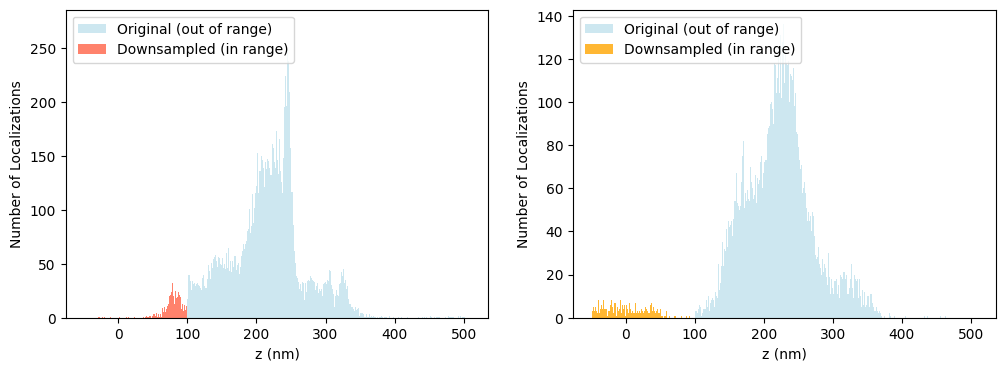

In [347]:
if downsample_mode ==1:
    z_min, z_max = -100,100  # Define the range for 'z' to downsample
    downsampling_factor_ch1 =6
    downsampling_factor_ch2 = 2
    save_path = "path_to_ROI/ds_hist_both_ch.png"
    
    # Assuming `data_table_ch1_ds` and `data_table_ch2_ds` are pandas DataFrames
    downsampled_data_ch1, downsampled_data_ch2, original_data_ch1, original_data_ch2 = data_downsampling(
        data_table_ch1_range_ROI, data_table_ch2_range_ROI,
        z_min, z_max,
        downsampling_factor_ch1, downsampling_factor_ch2,
        save_path
    )
    final_data_ch1 = pd.concat([downsampled_data_ch1, original_data_ch1])
    final_data_ch2 = pd.concat([downsampled_data_ch2, original_data_ch2])


file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


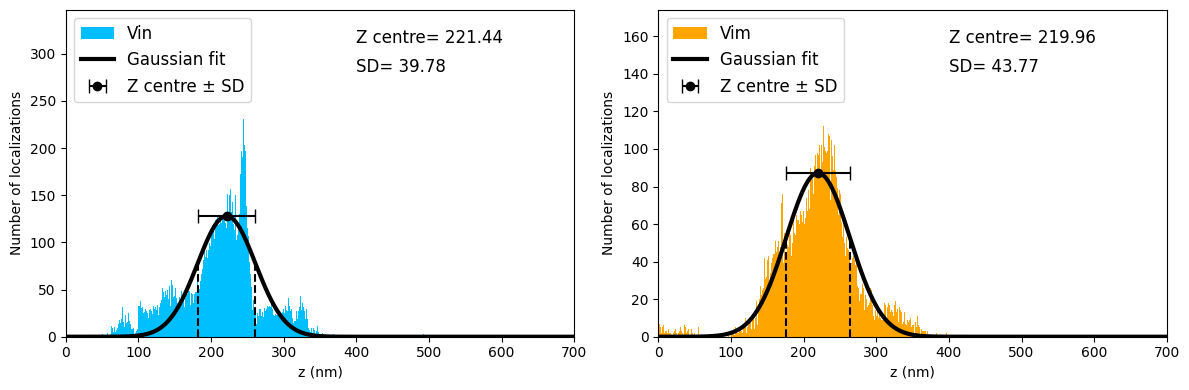

file saved in the directory: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


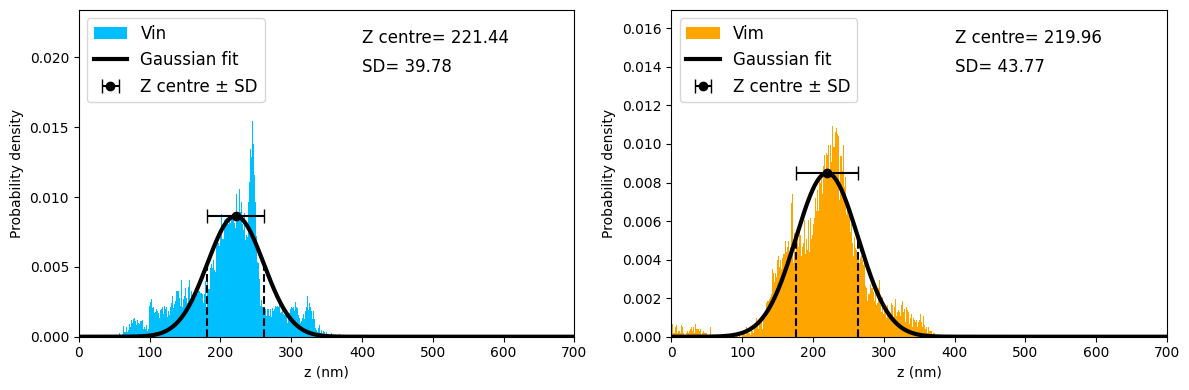

In [351]:
if downsample_mode ==1:
    # Call the functions
    %matplotlib inline
    plt.style.use('default')
    
    # Define the number of bins such that it gives 1nm in between bins
    his_bins = z_range_const
    
    # Non-normalized histograms
    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
    # GF and plot for each ch for non-normalized histogram and save
    popt_ch1 = fit_and_plot(ax1[0], final_data_ch1['UnwrappedZ_corrected'], his_bins, ch_col[0], ch_name[0][:3])
    popt_ch2 = fit_and_plot(ax1[1], final_data_ch2['UnwrappedZ_corrected'], his_bins, ch_col[1], ch_name[1][:3])
    
    plt.tight_layout()
    plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_ROI.png")
    print("file saved in the directory:", path_to_ROI)
    plt.show()
    plt.close(fig1) 
    
    # Subplots for normalized histograms
    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
    # GF and plot for each ch for normalized histogram
    popt_ch1_norm = fit_and_plot(ax2[0], final_data_ch1['UnwrappedZ_corrected'], his_bins, ch_col[0] , ch_name[0][:3], normalize=True)
    popt_ch2_norm = fit_and_plot(ax2[1], final_data_ch2['UnwrappedZ_corrected'], his_bins, ch_col[1], ch_name[1][:3], normalize=True)
    plt.tight_layout()
    
    plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_ROI_final.png")
    print("file saved in the directory:", path_to_ROI)
    plt.show()
    plt.close(fig2)  


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


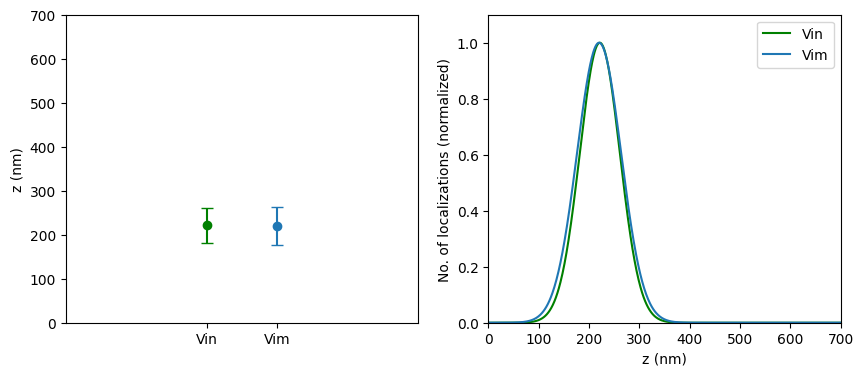

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16


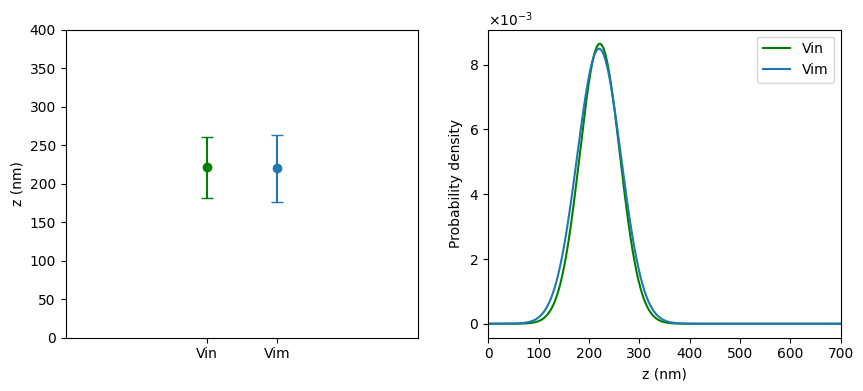

In [352]:
from matplotlib.ticker import ScalarFormatter
if downsample_mode ==1:
    A_opt_ch1, mu_opt_ch1, sig_opt_ch1 = popt_ch1[0]
    A_opt_ch2, mu_opt_ch2, sig_opt_ch2 = popt_ch2[0]
    x_model_ch1 = popt_ch1_norm[1]
    y_model_ch1 = popt_ch1_norm[2]
    
    x_model_ch2 = popt_ch2_norm[1]
    y_model_ch2 = popt_ch2_norm[2]
    
    print()
    fig, ax = plt.subplots(1,2,figsize=(10,4))
        
    ax[0].errorbar(ch_name[0][:3], mu_opt_ch1, abs(sig_opt_ch1), linestyle='None', marker='o',color="green",capsize=4,
                       label= ch_name[0][:3])
    
    ax[1].plot(x_model_ch1, y_model_ch1/max(y_model_ch1), label=(ch_name[0][:3]),color="green")
    
    if VIM_count == 1:
        ax[0].errorbar(ch_name[1][:3], mu_opt_ch2, abs(sig_opt_ch2), linestyle='None', marker='o',capsize=4,
                      label= ch_name[1][:3])
        ax[1].plot(x_model_ch2, y_model_ch2/max(y_model_ch2), label=(ch_name[1][:3]))
        
    #Set up graph1 
    ax[0].set_ylabel('z (nm)')
    #ax[0].legend()
    ax[0].set_xlim(-2,3)
    ax[0].set_ylim(0,z_range_const)
    #ax[0].legend(loc="upper left", scatterpoints=1, fontsize=8)
        
    #Set up graph2
    ax[1].set_xlabel('z (nm)')
    ax[1].set_ylabel('No. of localizations (normalized)')
    ax[1].legend()
    ax[1].set_xlim(0,z_range_const)
    ax[1].set_ylim(0,1.1)
    
    #Save a plot panel
    plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_max_to_be_1.png")
    print('Results are saved to the folder:', path_to_ROI)
    plt.show()
    
    #####################################
    
    
    A_opt_ch1, mu_opt_ch1, sig_opt_ch1 = popt_ch1_norm[0]
    A_opt_ch2, mu_opt_ch2, sig_opt_ch2 = popt_ch2_norm[0]
    x_model_ch1 = popt_ch1_norm[1]
    y_model_ch1 = popt_ch1_norm[2]
    
    x_model_ch2 = popt_ch2_norm[1]
    y_model_ch2 = popt_ch2_norm[2]
    
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
        
    ax[0].errorbar(ch_name[0][:3], mu_opt_ch1, abs(sig_opt_ch1), linestyle='None', marker='o',color="green",capsize=4,
                       label= ch_name[0][:3])
    
    ax[1].plot(x_model_ch1, y_model_ch1, label=(ch_name[0][:3]),color="green")
    
    if VIM_count == 1:
        ax[0].errorbar(ch_name[1][:3], mu_opt_ch2, abs(sig_opt_ch2), linestyle='None', marker='o',capsize=4,
                      label= ch_name[1][:3])
        
        ax[1].plot(x_model_ch2, y_model_ch2, label=(ch_name[1][:3]))
        
    #Set up graph1 
    ax[0].set_ylabel('z (nm)')
    #ax[0].legend()
    ax[0].set_xlim(-2,3)
    ax[0].set_ylim(0,400)
    #ax[0].legend(loc="upper left", scatterpoints=1, fontsize=8)
        
    #Set up graph2
    ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[1].set_xlabel('z (nm)')
    ax[1].set_ylabel('Probability density')
    ax[1].legend()
    ax[1].set_xlim(0,z_range_const)
    #ax[1].set_ylim(0,1.1)
    plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_to_probabilityDensity_final.png")
    print('Results are saved to the folder:', path_to_ROI)
    plt.show()

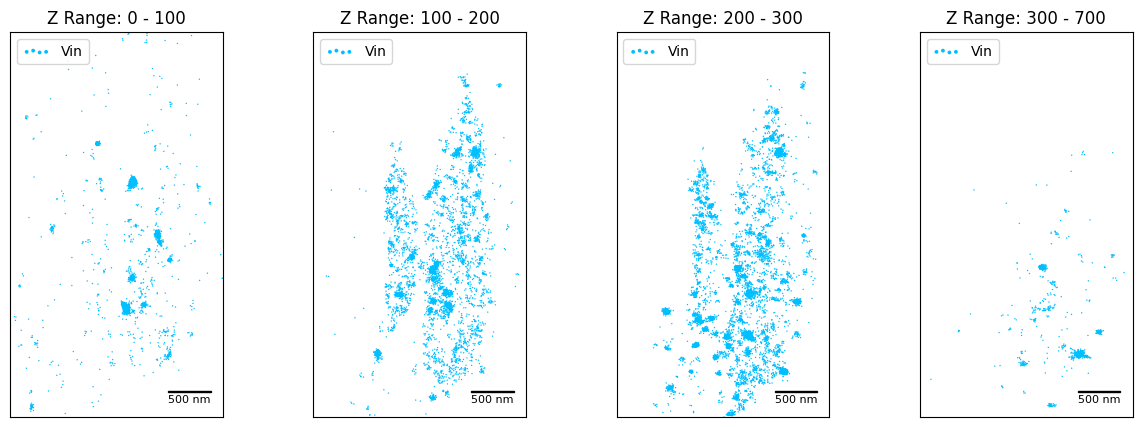

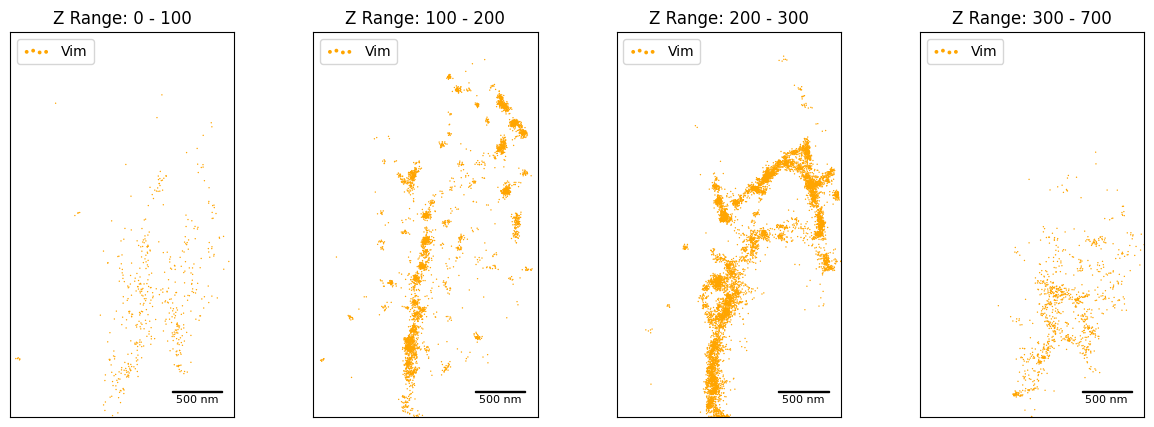

In [353]:
scalebar_length = 0.5  # length of the scale bar in data units
scalebar_label = '500 nm'  # label for the scale bar with micrometer abbreviation
#Plot z ranges
def plot_channel_data(final_data, channel_index, save_path, z):
    fig, axes = plt.subplots(1, (len(z)-1), figsize=(15, 5))
    
    for i in range(len(z)-1):
        # Filter the data for the current interval
        filtered_data = final_data[(final_data['UnwrappedZ_corrected'] >= z[i]) & (final_data['UnwrappedZ_corrected'] <= z[i+1])]
        
        # Scatter plot for the current interval
        axes[i].scatter(filtered_data['XPosition_mkm'], filtered_data['YPosition_mkm'],
                        marker='.', color=ch_col[channel_index], edgecolors='none',
                        label=ch_name[channel_index][:3], s=4)
        
        # Set title for the current subplot
        axes[i].set_title(f'Z Range: {z[i]} - {z[i+1]}')
        lgnd = axes[i].legend(loc="upper left", scatterpoints=4, fontsize=10)
        lgnd.legend_handles[0]._sizes = [30]
        #axes[i].set_xlabel(r'x ($\mu $m)')
        #axes[i].set_ylabel(r'y ($\mu $m)')
        axes[i].set_xlim(min(final_data['XPosition_mkm']),max(final_data['XPosition_mkm']))
        axes[i].set_ylim(min(final_data['YPosition_mkm']),max(final_data['YPosition_mkm']))
        axes[i].set_aspect('equal', 'box')
        # Define the scale bar size and label with micrometer abbreviation


        scalebar1 = AnchoredSizeBar(axes[i].transData, scalebar_length,scalebar_label,loc='lower right',pad=1,color='black',
                            frameon=False,size_vertical=0.01,fontproperties=FontProperties(size=8))
                            
        axes[i].add_artist(scalebar1)                           
        axes[i].set_xticks([])
        axes[i].set_yticks([])  



    with plt.rc_context({'savefig.dpi': 300}):
        fig.savefig(f"{save_path}//sliced_ROI_s_ch_{ch_name[channel_index]}.png")

    plt.show()

z = [0, 100, 200, 300,700]

# Plot for Channel 1
plot_channel_data(data_table_ch1_range_ROI, 0, path_to_ROI,z)

# Plot for Channel 2
plot_channel_data(data_table_ch2_range_ROI, 1, path_to_ROI,z)



## Vinculin may require 2peak fitting

In [354]:
peak_mode = 1

In [355]:
%matplotlib widget
from IPython.display import clear_output
from ipywidgets import widgets
def button_action_NO_2peak(_):
    global peak_mode
    peak_mode = 1 #no 2peak fitting
    with output:
        clear_output(wait=True)
        print("No 2-peak fitting")
        print("peak_mode = 1")

def button_action_2peak(_):
    global peak_mode
    peak_mode = 2
    with output:
        clear_output(wait=True)
        print("2-peak fitting will be performed")
        print("peak_mode = 2")


# Create buttons
peak = widgets.Button(description="No 2 peak fitting")
double_peak = widgets.Button(description="2 peak fitting")

# Attach button click events to functions
peak.on_click(button_action_NO_2peak)
double_peak.on_click(button_action_2peak)

output = widgets.Output()
display(peak, double_peak,output)





Button(description='No 2 peak fitting', style=ButtonStyle())

Button(description='2 peak fitting', style=ButtonStyle())

Output()

## 2 peak fit

In [356]:
def find_local_maxima(hist, bins):

    maxima = []
    
    # Exclude the first and last points as they cannot be local maxima
    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            x = 0.5 * (bins[i] + bins[i + 1])
            y = hist[i]
            maxima.append((x, y))

    return maxima

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

####
#parameter to sample histogram to see peakes of interest , other peak functions are not always working with low count areas

reduced_bins=10 #amount of bins in the histogram where local max are found , peaks of interest are 1 and 2


#data
if downsample_mode ==1:
    ch1_hist_ROI =final_data_ch1['UnwrappedZ_corrected']
    ch2_hist_ROI =final_data_ch1['UnwrappedZ_corrected']
else:
    ch1_hist_ROI = data_table_ch1_range_ROI['UnwrappedZ_corrected']
    ch2_hist_ROI = data_table_ch2_range_ROI['UnwrappedZ_corrected']
%matplotlib inline
####

if peak_mode ==2: #duble Gaus. needed

    # Create a histogram
    #his_bins = round(ch1_hist_ROI.max())
    his_bins = np.arange(0, z_range_const + 1, 1)
    fig2, ax = plt.subplots(1, 2, figsize=(10, 3))
    
    # Plot histogram
    ax[0].hist(ch1_hist_ROI, bins=his_bins, color='tomato', label='Vinculin')
    ax[0].legend(loc='upper right')
    
    
    
    # Create a histogram with HUGE bins to avoid wrong peak detection
    hist, bins, _ = ax[1].hist(ch1_hist_ROI, bins=reduced_bins, color='deepskyblue', label='Vinculin')
    # Find local maxima in the histogram
    maxima = find_local_maxima(hist, bins)
    ax[1].scatter(*zip(*maxima), color='tomato', label='Local Maxima (peak)')
    # Add text annotations to each point
    

    # Sort the maxima based on the y-values in descending order
    sorted_maxima = sorted(maxima, key=lambda x: x[1], reverse=True)

    # Select the top two peaks
    top_two_peaks = sorted_maxima[:2]
    top_two_peaks = sorted(top_two_peaks, key=lambda x: x[0])
    # Extract x and y coordinates of the top two peaks
    top_peak1_x, top_peak1_y = top_two_peaks[0]
    top_peak2_x, top_peak2_y = top_two_peaks[1]

    ax[1].scatter(*zip(*top_two_peaks), color='green', marker='x', label='Used local Maxima')

    x, y = zip(*maxima)
    for i, (xi, yi) in enumerate(maxima):
        plt.text(xi, yi, f'Peack {i+1}', fontsize=10, ha='right', va='bottom', color='darkslategrey')

    plt.show()
    ########
    
    #########
    print("Local Maxima:", maxima)

   
    
    # Assuming data_table_ch1_range_ROI is a DataFrame with a column 'UnwrappedZ'
    #ch1_hist_ROI = data_table_ch1_range_ROI['UnwrappedZ_corrected']
    
    # Create a histogram
  
    
    his_bins = np.arange(0, z_range_const + 1, 1)
    n_ch1, bins_ch1, _ = plt.hist(ch1_hist_ROI, bins=his_bins, color='deepskyblue', label='Vinculin', alpha=1)
    
    # Calculate bin centers
    x_data_ch1 = 0.5 * (bins_ch1[1:] + bins_ch1[:-1])
    
   

    # Initial guesses for fitting the double Gaussian
     #it is not very correct in tems of amplitude, counts are different but it's ok, sd also is taken as aprox. 
    initial_params_ch1 = [top_peak1_y,top_peak1_x,20, top_peak2_y,top_peak2_x,20 ]



    # Define double Gaussian function
    def double_gauss_f(x, A1, mu1, sig1, A2, mu2, sig2):
        return A1 * np.exp(-(x - mu1)**2 / (2 * sig1**2)) + A2 * np.exp(-(x - mu2)**2 / (2 * sig2**2))

    # Fit the data to the double Gaussian function
    popt2_peak_ch1, pcov_2peak_ch1 = curve_fit(double_gauss_f, x_data_ch1, n_ch1, p0=initial_params_ch1)

    # Extract parameters from the fit
    A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1 = popt2_peak_ch1

    # Generate the model curve using the fitted parameters
    y_model_ch1 = double_gauss_f(x_data_ch1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)

    # Plot the histogram, the double Gaussian fit, and individual components
    plt.plot(x_data_ch1, y_model_ch1, label='Double Gaussian fit', color='black', linewidth=2)
    plt.plot(x_data_ch1, A1_opt_ch1 * np.exp(-(x_data_ch1 - mu1_opt_ch1)**2 / (2 * sig1_opt_ch1**2)), label='Gauss. peak1', linestyle='--', color='green')
    plt.plot(x_data_ch1, A2_opt_ch1 * np.exp(-(x_data_ch1 - mu2_opt_ch1)**2 / (2 * sig2_opt_ch1**2)), label='Gauss. peak2', linestyle='--', color='deeppink')

    # Show the plot
    plt.legend()
    
   

    # Print the parameters of the double Gaussian fit
    print("Amplitude 1: ", A1_opt_ch1)
    print("mu 1: ", mu1_opt_ch1)
    print("sigma 1: ", sig1_opt_ch1)
    print("Amplitude 2: ", A2_opt_ch1)
    print("mu 2: ", mu2_opt_ch1)
    print("sigma 2: ", sig2_opt_ch1)

    results_peak1 = f"Peak 1:\nZ centre = {mu1_opt_ch1:.2f}\nSD = {sig1_opt_ch1:.2f}"
    results_peak2 = f"Peak 2:\nZ centre = {mu2_opt_ch1:.2f}\nSD = {sig2_opt_ch1:.2f}"

    # Add text annotations to the plot
    plt.annotate(results_peak1, xy=(0.7, 0.4), xycoords='axes fraction', fontsize=10)
    plt.annotate(results_peak2, xy=(0.7, 0.2), xycoords='axes fraction', fontsize=10)

    plt.savefig(path_to_ROI+ "//Double_Gaussian_fit_ROI.png")
    print('Results are saved to the folder:', path_to_ROI)
    plt.xlabel('z (nm)')
    
    plt.show()

else:
    print("2 pick fitting will not be performed")




2 pick fitting will not be performed


In [358]:
if peak_mode ==2:
    # Plot the histogram and double Gaussian fit
    plt.plot(x_data_ch1, y_model_ch1, label='Double Gaussian fit', color='black', linewidth=2)
    
    # Plot the first Gaussian component
    plt.plot(
        x_data_ch1,
        A1_opt_ch1 * np.exp(-(x_data_ch1 - mu1_opt_ch1)**2 / (2 * sig1_opt_ch1**2)),
        label='Gauss. peak1',
        linestyle='--',
        color='green'
    )
    
    # Plot the second Gaussian component
    plt.plot(
        x_data_ch1,
        A2_opt_ch1 * np.exp(-(x_data_ch1 - mu2_opt_ch1)**2 / (2 * sig2_opt_ch1**2)),
        label='Gauss. peak2',
        linestyle='--',
        color='deeppink'
    )
    
    # Highlight Z-center for the first peak
    y_center1 = double_gauss_f(mu1_opt_ch1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)  # Value at peak1
    plt.errorbar(mu1_opt_ch1, y_center1, xerr=sig1_opt_ch1, fmt='o', color='green', capsize=5, label='Z centre 1 ± SD')
    #plt.errorbar(mu1_opt_ch1, max(y_model_ch1), xerr=sig1_opt_ch1, fmt='o', color='green', capsize=5, label='Z centre 1 ± SD')

    
    sd_pos1 = mu1_opt_ch1 + sig1_opt_ch1
    sd_neg1 = mu1_opt_ch1 - sig1_opt_ch1
    y_sd_pos1 = double_gauss_f(sd_pos1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)
    y_sd_neg1 = double_gauss_f(sd_neg1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)
    plt.vlines([sd_pos1, sd_neg1], 0, [y_sd_pos1, y_sd_neg1], colors='green', linestyles='dashed')
    
    # Highlight Z-center for the second peak
    y_center2 = double_gauss_f(mu2_opt_ch1, 0, 0, 1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)  # Value at peak2
    wrongLabel=0
    if wrongLabel==0:
        plt.errorbar(mu2_opt_ch1, y_center2, xerr=sig2_opt_ch1, fmt='o', color='deeppink', capsize=5, label='Z centre 2 ± SD')
  
    
    sd_pos2 = mu2_opt_ch1 + sig2_opt_ch1
    sd_neg2 = mu2_opt_ch1 - sig2_opt_ch1
    y_sd_pos2 = double_gauss_f(sd_pos2, 0, 0, 1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)
    y_sd_neg2 = double_gauss_f(sd_neg2, 0, 0, 1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)
    plt.vlines([sd_pos2, sd_neg2], 0, [y_sd_pos2, y_sd_neg2], colors='deeppink', linestyles='dashed')
    
    # Add annotations for the peaks
    results_peak1 = f"Peak 1:\nZ centre = {mu1_opt_ch1:.2f}\nSD = {sig1_opt_ch1:.2f}"
    results_peak2 = f"Peak 2:\nZ centre = {mu2_opt_ch1:.2f}\nSD = {sig2_opt_ch1:.2f}"
    plt.annotate(results_peak1, xy=(0.7, 0.4), xycoords='axes fraction', fontsize=10)
    plt.annotate(results_peak2, xy=(0.7, 0.2), xycoords='axes fraction', fontsize=10)
    
    # Labels, legends, and saving the plot
    plt.xlabel('z (nm)')
    plt.ylabel('Number of localizations')
    plt.legend(loc='upper right')
    plt.savefig(path_to_ROI + "/Double_Gaussian_fit_ROI_marked_color.png")
    plt.show()


In [359]:
if peak_mode ==2:
    # Plot the histogram and double Gaussian fit
    plt.plot(x_data_ch1, y_model_ch1, label='Double Gaussian fit', color='black', linewidth=2)
    
    # Plot the first Gaussian component
    plt.plot(
        x_data_ch1,
        A1_opt_ch1 * np.exp(-(x_data_ch1 - mu1_opt_ch1)**2 / (2 * sig1_opt_ch1**2)),
        label='Gauss. peak1',
        linestyle='--',
        color='green'
    )
    
    # Plot the second Gaussian component
    plt.plot(
        x_data_ch1,
        A2_opt_ch1 * np.exp(-(x_data_ch1 - mu2_opt_ch1)**2 / (2 * sig2_opt_ch1**2)),
        label='Gauss. peak2',
        linestyle='--',
        color='deeppink'
    )
    
    # Highlight Z-center for the first peak
    y_center1 = double_gauss_f(mu1_opt_ch1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)  # Value at peak1
    plt.errorbar(mu1_opt_ch1, y_center1, xerr=sig1_opt_ch1, fmt='o', color='green', capsize=5, label='Z centre 1 ± SD')
    #plt.errorbar(mu1_opt_ch1, max(y_model_ch1), xerr=sig1_opt_ch1, fmt='o', color='green', capsize=5, label='Z centre 1 ± SD')

    
    sd_pos1 = mu1_opt_ch1 + sig1_opt_ch1
    sd_neg1 = mu1_opt_ch1 - sig1_opt_ch1
    y_sd_pos1 = double_gauss_f(sd_pos1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)
    y_sd_neg1 = double_gauss_f(sd_neg1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)
    plt.vlines([sd_pos1, sd_neg1], 0, [y_sd_pos1, y_sd_neg1], colors='green', linestyles='dashed')
    
    # Highlight Z-center for the second peak
    y_center2 = double_gauss_f(mu2_opt_ch1, 0, 0, 1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)  # Value at peak2
    
    wrongLabel=1
    rangeForsecondPeack=200
    
    if wrongLabel==0:
        plt.errorbar(mu2_opt_ch1, y_center2, xerr=sig2_opt_ch1, fmt='o', color='deeppink', capsize=5, label='Z centre 2 ± SD')
    else:
        # Filter the data to select only rows where x_data_ch1 > 120
        filtered_x_data_ch1 = x_data_ch1[x_data_ch1 > rangeForsecondPeack]
        filtered_y_model_ch1 = y_model_ch1[x_data_ch1 > rangeForsecondPeack]
        plt.errorbar(mu2_opt_ch1, max(filtered_y_model_ch1), xerr=sig2_opt_ch1, fmt='o', color='green', capsize=5, label='Z centre 1 ± SD')
      
    sd_pos2 = mu2_opt_ch1 + sig2_opt_ch1
    sd_neg2 = mu2_opt_ch1 - sig2_opt_ch1
    y_sd_pos2 = double_gauss_f(sd_pos2, 0, 0, 1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)
    y_sd_neg2 = double_gauss_f(sd_neg2, 0, 0, 1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)
    plt.vlines([sd_pos2, sd_neg2], 0, [y_sd_pos2, y_sd_neg2], colors='deeppink', linestyles='dashed')
    
    # Add annotations for the peaks
    results_peak1 = f"Peak 1:\nZ centre = {mu1_opt_ch1:.2f}\nSD = {sig1_opt_ch1:.2f}"
    results_peak2 = f"Peak 2:\nZ centre = {mu2_opt_ch1:.2f}\nSD = {sig2_opt_ch1:.2f}"
    plt.annotate(results_peak1, xy=(0.7, 0.4), xycoords='axes fraction', fontsize=10)
    plt.annotate(results_peak2, xy=(0.7, 0.2), xycoords='axes fraction', fontsize=10)
    
    # Labels, legends, and saving the plot
    plt.xlabel('z (nm)')
    plt.ylabel('Number of localizations')
    plt.legend(loc='upper right')
    plt.savefig(path_to_ROI + "/Double_Gaussian_fit_ROI_marked_color.png")
    plt.show()


In [360]:
if peak_mode ==2:

    # Normalize the histogram to represent probability density
    n_ch1, bins_ch1 = np.histogram(ch1_hist_ROI, bins=his_bins, density=True)
    x_data_ch1 = 0.5 * (bins_ch1[1:] + bins_ch1[:-1])  # Calculate bin centers
    
    # Define double Gaussian function
    def double_gauss_f(x, A1, mu1, sig1, A2, mu2, sig2):
        return A1 * np.exp(-(x - mu1)**2 / (2 * sig1**2)) + A2 * np.exp(-(x - mu2)**2 / (2 * sig2**2))
    
    # Initial guesses for fitting the double Gaussian
    initial_params_ch1 = [
        max(n_ch1), top_peak1_x, 20,  # First Gaussian peak
        max(n_ch1) / 2, top_peak2_x, 20  # Second Gaussian peak
    ]
    
    # Fit the data to the double Gaussian function
    popt2_peak_ch1, pcov_2peak_ch1 = curve_fit(double_gauss_f, x_data_ch1, n_ch1, p0=initial_params_ch1)
    
    # Extract parameters from the fit
    A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1 = popt2_peak_ch1
    
    # Generate the model curve using the fitted parameters
    y_model_ch1 = double_gauss_f(x_data_ch1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, A2_opt_ch1, mu2_opt_ch1, sig2_opt_ch1)
    
    # Plot the histogram as a probability density and the fit
    plt.figure(figsize=(8, 6))
    plt.hist(ch1_hist_ROI, bins=his_bins, density=True, color='deepskyblue', alpha=0.6, label='VIN')
    plt.plot(x_data_ch1, y_model_ch1, label='Double Gaussian fit (prob. density)', color='black', linewidth=2)
    
    # Plot individual Gaussian components
    #plt.plot(
    #    x_data_ch1,
    #    A1_opt_ch1 * np.exp(-(x_data_ch1 - mu1_opt_ch1)**2 / (2 * sig1_opt_ch1**2)),
    #    label='Gaussian (peak 1)',
    #   linestyle='--',
    #    color='black'
    #)
    #plt.plot(
    #    x_data_ch1,
    #    A2_opt_ch1 * np.exp(-(x_data_ch1 - mu2_opt_ch1)**2 / (2 * sig2_opt_ch1**2)),
    #    label='Gaussian (peak 2)',
    #    linestyle='--',
    #    color='black'
    #)
    
    # Highlight Z-center ± SD for each peak
    # Highlight Z-center for the first peak
    y_center1 = double_gauss_f(mu1_opt_ch1, A1_opt_ch1, mu1_opt_ch1, sig1_opt_ch1, 0, 0, 1)  # Value at peak1
    plt.errorbar(mu1_opt_ch1, y_center1, xerr=sig1_opt_ch1, fmt='o', color='black', capsize=5, label='Z centre 1 ± SD')
    #plt.errorbar(mu1_opt_ch1, max(y_model_ch1), xerr=sig1_opt_ch1, fmt='o', color='black', capsize=5, label='Z centre 1 ± SD')
    wrongLabel=1
    rangeForsecondPeack=200
    if wrongLabel==0:
        plt.errorbar(mu2_opt_ch1, y_center2, xerr=sig2_opt_ch1, fmt='o', color='deeppink', capsize=5, label='Z centre 2 ± SD')
        A2_opt_ch1_mark= A2_opt_ch1
    else:
        # Filter the data to select only rows where x_data_ch1 > 120
        filtered_x_data_ch1 = x_data_ch1[x_data_ch1 > rangeForsecondPeack]
        filtered_y_model_ch1 = y_model_ch1[x_data_ch1 > rangeForsecondPeack]
        plt.errorbar(mu2_opt_ch1, max(filtered_y_model_ch1), xerr=sig2_opt_ch1, fmt='o', color='black', capsize=5)
        A2_opt_ch1_mark = max(filtered_y_model_ch1)
      
    
    # Add vertical lines for Z-center ± SD
    plt.vlines(
        [mu1_opt_ch1 - sig1_opt_ch1, mu1_opt_ch1 + sig1_opt_ch1],
        0,
        [A1_opt_ch1, A1_opt_ch1],
        colors='black',
        linestyles='dashed'
    )
    plt.vlines(
        [mu2_opt_ch1 - sig2_opt_ch1, mu2_opt_ch1 + sig2_opt_ch1],
        0,
        [A2_opt_ch1_mark, A2_opt_ch1_mark],
        colors='black',
        linestyles='dashed'
    )
    
    # Annotate the results for each peak
    results_peak1 = f"Peak 1:\nZ centre = {mu1_opt_ch1:.2f}\nSD = {sig1_opt_ch1:.2f}"
    results_peak2 = f"Peak 2:\nZ centre = {mu2_opt_ch1:.2f}\nSD = {sig2_opt_ch1:.2f}"
    plt.annotate(results_peak1, xy=(0.7, 0.4), xycoords='axes fraction', fontsize=12)
    plt.annotate(results_peak2, xy=(0.7, 0.2), xycoords='axes fraction', fontsize=12)
    
    # Labels and legend
    plt.xlabel('z (nm)')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper right')
    plt.title('Double Gaussian Fit (Vin)')
    plt.grid(False)
    
    # Save the plot
    plt.savefig(path_to_ROI + "/Double_Gaussian_fit_probability_density.png")
    plt.show()


In [361]:
if peak_mode == 2:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    import matplotlib.ticker as ticker
    #for Vin
    mean_values = [mu1_opt_ch1, mu2_opt_ch1]
    sd_values = [sig1_opt_ch1, sig2_opt_ch1]
    color_vin = ["green",'tomato']
    for i in range(len(mean_values)):
        ax[0].errorbar(x=ch_name[0][:3], y=mean_values[i], yerr=sd_values[i], linestyle='None', marker='o', capsize=4,
                   label=ch_name[0][:3], color=color_vin[i])
    ax[0].errorbar(x=ch_name[1][:3], y=mu_opt_ch2, yerr=sig_opt_ch2, linestyle='None', marker='o',capsize=4,
                      label= ch_name[1][:3])
        
        
    #Set up graph1 
    ax[0].set_ylabel('z (nm)')
    
    ax[0].set_xlim(-2,3)
    ax[0].set_ylim(0,400) #z_range_const too large
    
    
    
    ax[1].plot(x_data_ch1, A1_opt_ch1 * np.exp(-(x_data_ch1 - mu1_opt_ch1) ** 2 / (2 * sig1_opt_ch1 ** 2)),
                 label=ch_name[0][:3], linestyle='-', color='green')
    ax[1].plot(x_data_ch1, A2_opt_ch1 * np.exp(-(x_data_ch1 - mu2_opt_ch1) ** 2 / (2 * sig2_opt_ch1 ** 2)),
                 linestyle='-', color='tomato',label=ch_name[0][:3])
    ax[1].plot(x_model_ch2, y_model_ch2, label=(ch_name[1][:3]))
    
    #Set up graph2
    ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[1].set_xlabel('z (nm)')
    ax[1].set_ylabel('Probability density')
    ax[1].legend()
    ax[1].set_xlim(0,z_range_const)
    
    plt.savefig(path_to_ROI+ "//gaus_bar_2ch_final_normolised_to_probabilityDensity_2peakVin.png")


# Save into files


In [362]:
import os
import json

if VIM_count == 1: 
    output_file = 'output_z_' + str(z_range_const) + '.txt'
    file_path_VIN = os.path.join(parent_dir, output_file)
    
    # Your data structure
    structure_to_save_VIN = {
        'ROI_name': roi_name,
        'coordinates': data_poly,
        'z_center_ch1': round(mu_opt_ch1, 2),
        'sd_ch1': round(sig_opt_ch1, 2),
        'z_center_ch2': round(mu_opt_ch2, 2),
        'sd_ch2': round(sig_opt_ch2, 2),
        '1_or_2_peak_fit': peak_mode,
        'downsampling': downsample_mode
    }
    
    # Check if file exists and has content
    if os.path.exists(file_path_VIN) and os.path.getsize(file_path_VIN) > 0:
        # File exists and has content, read it first
        with open(file_path_VIN, 'r') as file:
            datasets = json.load(file)
    else:
        # File does not exist or is empty, start with an empty list
        datasets = []
    
    # Check for an existing ROI_name and overwrite it
    for idx, dataset in enumerate(datasets):
        if dataset.get('ROI_name') == roi_name:
            datasets[idx] = structure_to_save_VIN  # Overwrite the entry
            break
    else:
        # If ROI_name does not exist, append the new structure
        datasets.append(structure_to_save_VIN)
    
    # Save the updated list of dictionaries to the file in JSON format
    with open(file_path_VIN, 'w') as file:
        json.dump(datasets, file, indent=4)  # Using indent for better readability
    
    print(f'Data is saved to {file_path_VIN}')


Data is saved to /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/output_z_700.txt


In [365]:
if VIM_count == 1:
    table_output_ROI.add_row([roi_name,round(mu_opt_ch1,2),round(sig_opt_ch1,2),round(mu_opt_ch2,2),round(sig_opt_ch2,2),downsample_mode,peak_mode])
    print(table_output_ROI)
else: print(f'Data is not put into table, becasue there is not enougth data in VIM within ROI')

ROI_ind z_center_ch1 sd_ch1 z_center_ch2 sd_ch2 downsampling 1_or_2_peak_fit
------- ------------ ------ ------------ ------ ------------ ---------------
                 0.0    0.0          0.0    0.0            0               1
 ROI_16       221.44  39.78       219.96  43.77            1               1


In [366]:
if peak_mode == 2:
    table_output_ROI_2peak.add_row([roi_name,round(mu1_opt_ch1,2),round(sig1_opt_ch1,2), round(mu2_opt_ch1,2),round(sig2_opt_ch1,2),round(mu_opt_ch2,2),round(sig_opt_ch2,2),downsample_mode,peak_mode])
    print(table_output_ROI_2peak)
else: print(f'Data is not put into table, becasue there is no 2 peak fit used')



Data is not put into table, becasue there is no 2 peak fit used


In [367]:
import csv
def add_row_to_file(row, filename):
    if os.path.exists(filename):
        with open(filename, 'r', newline='') as file:
            reader = csv.reader(file)
            for existing_row in reader:
                if row[0] == existing_row[0]:
                    print("Row already exists")
                    return

    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)
        print("Row added successfully")

# Convert the data to a list
if VIM_count == 1:
    row = [roi_name, round(mu_opt_ch1, 2), round(sig_opt_ch1, 2), round(mu_opt_ch2, 2), round(sig_opt_ch2, 2), downsample_mode, peak_mode]
    output_file_path = os.path.join(parent_dir, 'output_data.txt')
    add_row_to_file(row, output_file_path)


# Convert the data to a list
#if VIM_count == 1 and peak_mode == 2:
#    row = [roi_name,round(mu1_opt_ch1,2),round(sig1_opt_ch1,2), round(mu2_opt_ch1,2),round(sig2_opt_ch1,2),round(mu_opt_ch2,2),round(sig_opt_ch2,2),downsample_mode,peak_mode]
#    output_file_path = os.path.join(parent_dir, 'output_data_2_peak.txt')
#    add_row_to_file(row, output_file_path)


Row already exists


In [270]:
if peak_mode==2 :
    row_2peak = [roi_name, round(mu1_opt_ch1,2),round(sig1_opt_ch1,2), round(mu2_opt_ch1,2),round(sig2_opt_ch1,2), round(mu_opt_ch2, 2), round(sig_opt_ch2, 2), downsample_mode, 2]

    output_file_path_2peak = os.path.join(parent_dir, 'output_data_2_peak.txt')
    
    add_row_to_file(row_2peak, output_file_path_2peak)
    ########add into table and show
    table_output_ROI_2peak.add_row(row_2peak)
    print(table_output_ROI_2peak)

## The VIN peak and the VIM peak are "not away" from each other better to visualise ROI over whole z range  

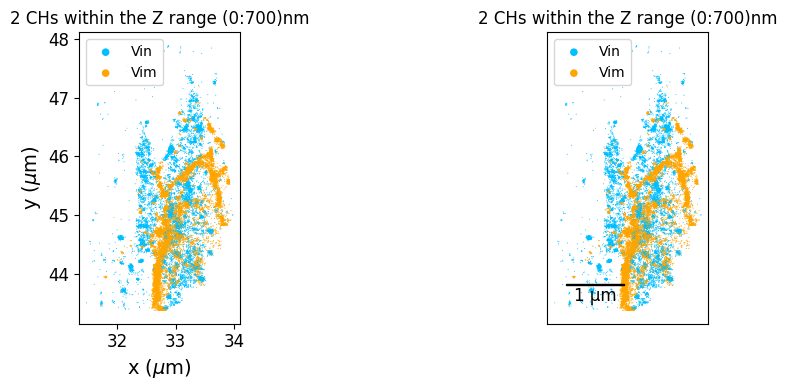

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//View_Data_ROI_z_0-zrange_topView_2D.png


In [368]:
m=0.5
fig_roi, ax_roi = plt.subplots(1, 2, figsize=(12, 4))

x_ch1 = data_table_ch1_range_ROI['XPosition_mkm']
y_ch1 = data_table_ch1_range_ROI['YPosition_mkm']

    
x_ch2 = data_table_ch2_range_ROI['XPosition_mkm']
y_ch2 = data_table_ch2_range_ROI['YPosition_mkm']


title_pic= "2 CHs within the Z range (0:"+ str(z_range_const)+')nm'
ax_roi[0].scatter(x_ch1, y_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none') 
ax_roi[0].scatter(x_ch2, y_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none') 
ax_roi[0].set_title(title_pic)
ax_roi[0].set_aspect('equal', 'box')
ax_roi[0].set_xlabel(r'x ($\mu $m)', fontsize=14)
ax_roi[0].set_ylabel(r'y ($\mu $m)', fontsize=14)
ax_roi[0].tick_params(axis='both', which='major', labelsize=12) 



# Second subplot
title_pic= "2 CHs within the Z range (0:"+ str(z_range_const)+')nm'
ax_roi[1].scatter(x_ch1, y_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none') 
ax_roi[1].scatter(x_ch2, y_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none') 
ax_roi[1].set_title(title_pic)
ax_roi[1].set_aspect('equal', 'box')




# Define the scale bar size and label with micrometer abbreviation
scalebar_length = 1  # length of the scale bar in data units
scalebar_label = '1 µm'  # label for the scale bar with micrometer abbreviation

# Define font properties for the scale bar


# Add scale bar to the first subplot
scalebar1 = AnchoredSizeBar(ax_roi[0].transData, scalebar_length,scalebar_label,loc='lower left',pad=1,color='black',
                            frameon=False,size_vertical=0.01,fontproperties=FontProperties(size=12))
                            
ax_roi[1].add_artist(scalebar1)                           
ax_roi[1].set_xticks([])
ax_roi[1].set_yticks([])  


for ax in ax_roi:

    lgnd = ax.legend(loc="upper left", scatterpoints=1, fontsize=10)
    lgnd.legend_handles[0]._sizes = [30]
    lgnd.legend_handles[1]._sizes = [30]
plt.tight_layout()

fig_roi.savefig(path_to_ROI+ "//View_Data_ROI_z_0-zrange_topView_2D.png",dpi=300)
plt.show()
print('Results are saved to the folder:', path_to_ROI+ "//View_Data_ROI_z_0-zrange_topView_2D.png")

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//View_Data_ROI_z_0-zrange_sideView_2D.png


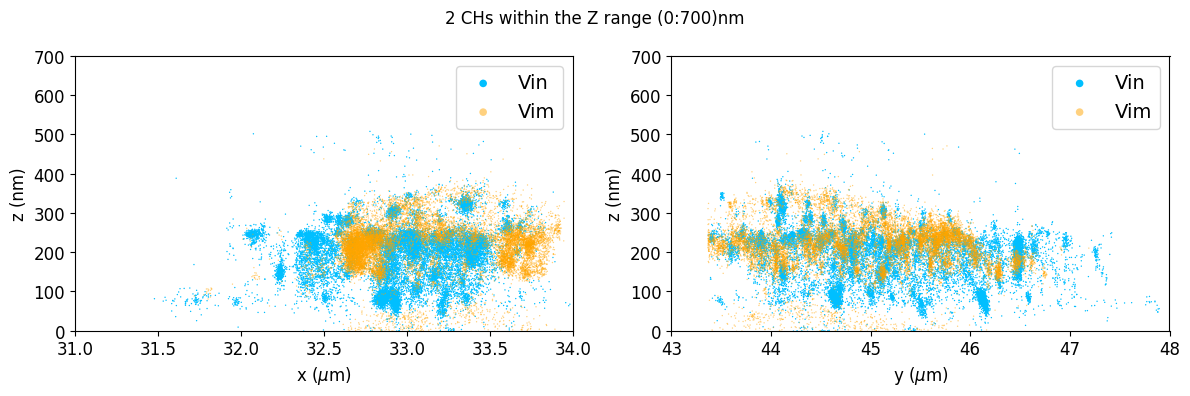

In [369]:
m=1
x_ch1 = data_table_ch1_range_ROI['XPosition_mkm']
y_ch1 = data_table_ch1_range_ROI['YPosition_mkm']
z_ch1 = data_table_ch1_range_ROI['UnwrappedZ_corrected']
    
x_ch2 = data_table_ch2_range_ROI['XPosition_mkm']
y_ch2 = data_table_ch2_range_ROI['YPosition_mkm']
z_ch2 = data_table_ch2_range_ROI['UnwrappedZ_corrected']


fig_side, ax = plt.subplots(1,2,figsize=(12,4))
title_pic= "2 CHs within the Z range (0:"+ str(z_range_const)+')nm'
fig_side.suptitle(title_pic)
    
ax[0].scatter(x_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[0].scatter(x_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none',alpha=0.5)
ax[0].set_xlim(math.floor(min(x_ch1)), math.ceil(max(x_ch1))) #math.floor and math.ceil rounding to up and down int
    
ax[1].scatter(y_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[1].scatter(y_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none',alpha=0.5)
ax[1].set_xlim(math.floor(min(y_ch1)),   math.ceil(max(y_ch1)))
#settings
    
ax[0].set_xlabel(r'x ($\mu $m)', fontsize=12)
ax[1].set_xlabel(r'y ($\mu $m)', fontsize=12)
# common settings for both plots
i=0
for axs in ax.flat:
    #axs.legend(loc="upper right", fontsize=14)
    axs.set_ylabel(r'z (nm)', fontsize=12)
    axs.set_ylim(0,z_range_const)
    axs.tick_params(axis='both', which='major', labelsize=12) 
    lgnd = axs.legend(loc="upper right", scatterpoints=1, fontsize=14)
    lgnd.legend_handles[0]._sizes = [30]
    lgnd.legend_handles[1]._sizes = [30]
    
    
    i+=1
plt.tight_layout()  
plt.savefig(path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D.png", dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D.png")
plt.show()

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//View_Data_ROI_z_0-zrange_sideView_2D_ylim400.png


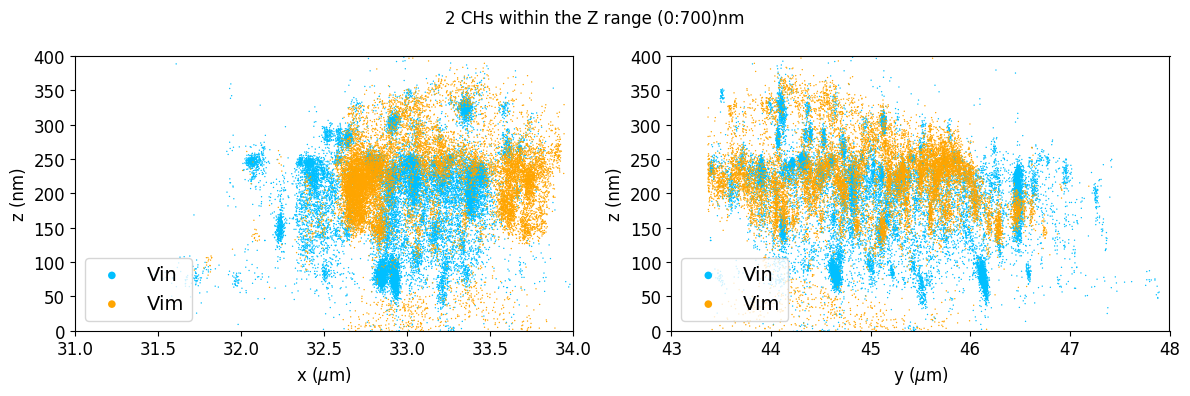

In [370]:
m=1
x_ch1 = data_table_ch1_range_ROI['XPosition_mkm']
y_ch1 = data_table_ch1_range_ROI['YPosition_mkm']
z_ch1 = data_table_ch1_range_ROI['UnwrappedZ_corrected']
    
x_ch2 = data_table_ch2_range_ROI['XPosition_mkm']
y_ch2 = data_table_ch2_range_ROI['YPosition_mkm']
z_ch2 = data_table_ch2_range_ROI['UnwrappedZ_corrected']


fig_side, ax = plt.subplots(1,2,figsize=(12,4))
title_pic= "2 CHs within the Z range (0:"+ str(z_range_const)+')nm'
fig_side.suptitle(title_pic)
    
ax[0].scatter(x_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[0].scatter(x_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none')
ax[0].set_xlim(math.floor(min(x_ch1)), math.ceil(max(x_ch1))) #math.floor and math.ceil rounding to up and down int
    
ax[1].scatter(y_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[1].scatter(y_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none')
ax[1].set_xlim(math.floor(min(y_ch1)),   math.ceil(max(y_ch1)))
#settings
    
ax[0].set_xlabel(r'x ($\mu $m)', fontsize=12)
ax[1].set_xlabel(r'y ($\mu $m)', fontsize=12)
# common settings for both plots
i=0
for axs in ax.flat:
    #axs.legend(loc="upper right", fontsize=14)
    axs.set_ylabel(r'z (nm)', fontsize=12)
    axs.set_ylim(0,400)
    axs.tick_params(axis='both', which='major', labelsize=12) 
    lgnd = axs.legend(loc="lower left", scatterpoints=1, fontsize=14)
    lgnd.legend_handles[0]._sizes = [30]
    lgnd.legend_handles[1]._sizes = [30]
    
    
    i+=1
plt.tight_layout()  
plt.savefig(path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D.png", dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D_ylim400.png")
plt.show()

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//View_Data_ROI_z_0-zrange_sideView_2D_scaleBar.png


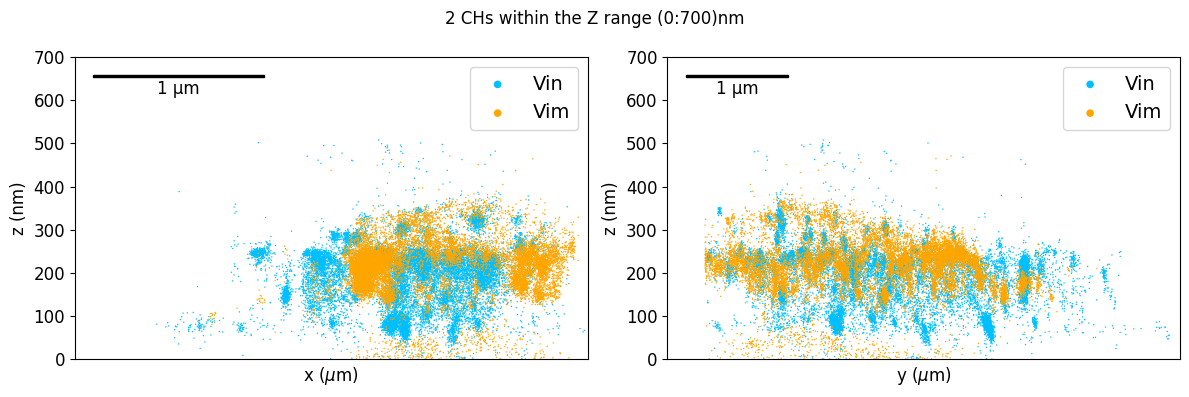

In [371]:
m=1
x_ch1 = data_table_ch1_range_ROI['XPosition_mkm']
y_ch1 = data_table_ch1_range_ROI['YPosition_mkm']
z_ch1 = data_table_ch1_range_ROI['UnwrappedZ_corrected']
    
x_ch2 = data_table_ch2_range_ROI['XPosition_mkm']
y_ch2 = data_table_ch2_range_ROI['YPosition_mkm']
z_ch2 = data_table_ch2_range_ROI['UnwrappedZ_corrected']


fig_side, ax = plt.subplots(1,2,figsize=(12,4))
title_pic= "2 CHs within the Z range (0:"+ str(z_range_const)+')nm'
fig_side.suptitle(title_pic)
    
ax[0].scatter(x_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[0].scatter(x_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none',alpha=1)
ax[0].set_xlim(math.floor(min(x_ch1)), math.ceil(max(x_ch1))) #math.floor and math.ceil rounding to up and down int
    
ax[1].scatter(y_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[1].scatter(y_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none',alpha=1)
ax[1].set_xlim(math.floor(min(y_ch1)),   math.ceil(max(y_ch1)))
#settings
    
ax[0].set_xlabel(r'x ($\mu $m)', fontsize=12)
ax[1].set_xlabel(r'y ($\mu $m)', fontsize=12)
# common settings for both plots
i=0
for axs in ax.flat:
    #axs.legend(loc="upper right", fontsize=14)
    axs.set_ylabel(r'z (nm)', fontsize=12)
    axs.set_ylim(0,z_range_const)
    axs.tick_params(axis='both', which='major', labelsize=12) 
    lgnd = axs.legend(loc="upper right", scatterpoints=1, fontsize=14)
    lgnd.legend_handles[0]._sizes = [30]
    lgnd.legend_handles[1]._sizes = [30]
    
    
    i+=1

# Define the scale bar size and label with micrometer abbreviation
scalebar_length = 1  # length of the scale bar in data units
scalebar_label = '1 µm'  # label for the scale bar with micrometer abbreviation

# Define font properties for the scale bar


# Add scale bar to the first subplot
scalebar1 = AnchoredSizeBar(ax[0].transData, scalebar_length,scalebar_label,loc='upper left',pad=1,color='black',
                            frameon=False,size_vertical=4,fontproperties=FontProperties(size=12))
                            
ax[0].add_artist(scalebar1)                           
ax[0].set_xticks([])

scalebar1 = AnchoredSizeBar(ax[1].transData, scalebar_length,scalebar_label,loc='upper left',pad=1,color='black',
                            frameon=False,size_vertical=4,fontproperties=FontProperties(size=12))
                            
ax[1].add_artist(scalebar1)                           
ax[1].set_xticks([])

plt.tight_layout()  
plt.savefig(path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D_scaleBar.png", dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D_scaleBar.png")
plt.show()

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21/ROI_16//View_Data_ROI_z_0-zrange_sideView_2D_scaleBar_ylim400.png


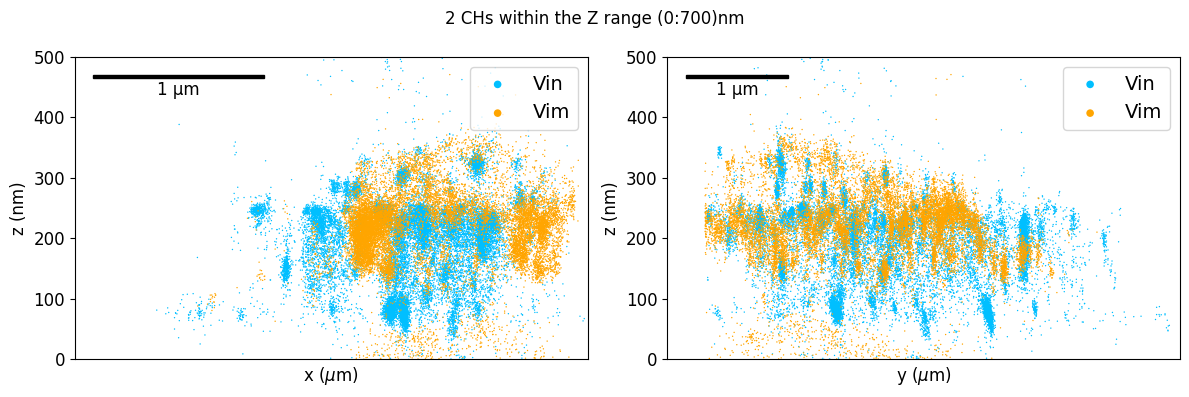

In [372]:
m=1
x_ch1 = data_table_ch1_range_ROI['XPosition_mkm']
y_ch1 = data_table_ch1_range_ROI['YPosition_mkm']
z_ch1 = data_table_ch1_range_ROI['UnwrappedZ_corrected']
    
x_ch2 = data_table_ch2_range_ROI['XPosition_mkm']
y_ch2 = data_table_ch2_range_ROI['YPosition_mkm']
z_ch2 = data_table_ch2_range_ROI['UnwrappedZ_corrected']


fig_side, ax = plt.subplots(1,2,figsize=(12,4))
title_pic= "2 CHs within the Z range (0:"+ str(z_range_const)+')nm'
fig_side.suptitle(title_pic)
    
ax[0].scatter(x_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[0].scatter(x_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none',alpha=1)
ax[0].set_xlim(math.floor(min(x_ch1)), math.ceil(max(x_ch1))) #math.floor and math.ceil rounding to up and down int
    
ax[1].scatter(y_ch1, z_ch1, c= ch_col[0], s=m, label= ch_name[0][:3],edgecolor='none')
ax[1].scatter(y_ch2, z_ch2, c= ch_col[1], s=m, label= ch_name[1][:3],edgecolor='none',alpha=1)
ax[1].set_xlim(math.floor(min(y_ch1)),   math.ceil(max(y_ch1)))
#settings
    
ax[0].set_xlabel(r'x ($\mu $m)', fontsize=12)
ax[1].set_xlabel(r'y ($\mu $m)', fontsize=12)
# common settings for both plots
i=0
for axs in ax.flat:
    #axs.legend(loc="upper right", fontsize=14)
    axs.set_ylabel(r'z (nm)', fontsize=12)
    axs.set_ylim(0,500)
    axs.tick_params(axis='both', which='major', labelsize=12) 
    lgnd = axs.legend(loc="upper right", scatterpoints=1, fontsize=14)
    lgnd.legend_handles[0]._sizes = [30]
    lgnd.legend_handles[1]._sizes = [30]
    
    
    i+=1

# Define the scale bar size and label with micrometer abbreviation
scalebar_length = 1  # length of the scale bar in data units
scalebar_label = '1 µm'  # label for the scale bar with micrometer abbreviation

# Define font properties for the scale bar


# Add scale bar to the first subplot
scalebar1 = AnchoredSizeBar(ax[0].transData, scalebar_length,scalebar_label,loc='upper left',pad=1,color='black',
                            frameon=False,size_vertical=4,fontproperties=FontProperties(size=12))
                            
ax[0].add_artist(scalebar1)                           
ax[0].set_xticks([])

scalebar1 = AnchoredSizeBar(ax[1].transData, scalebar_length,scalebar_label,loc='upper left',pad=1,color='black',
                            frameon=False,size_vertical=4,fontproperties=FontProperties(size=12))
                            
ax[1].add_artist(scalebar1)                           
ax[1].set_xticks([])

plt.tight_layout()  
plt.savefig(path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D_scaleBar.png", dpi=300)
print('Results are saved to the folder:', path_to_ROI+ "//View_Data_ROI_z_0-zrange_sideView_2D_scaleBar_ylim400.png")
plt.show()

In [279]:
%matplotlib inline


x1 = data_table_ch1_range['XPosition_mkm']
y1 = data_table_ch1_range['YPosition_mkm']

x2 = data_table_ch2_range['XPosition_mkm']
y2 = data_table_ch2_range['YPosition_mkm']



x_coords, y_coords = zip(*polygon_nodes_coord)
# Create a scatter plot
fig1, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x1, y1,  s=0.5, label= ch_name[0][:3],marker='.', color= ch_col[0],edgecolors='none',alpha=1)
ax.scatter(x2, y2, s=0.1, label= ch_name[1][:3],marker='.', color= ch_col[1],alpha=1,edgecolors='none')

plt.plot(x_coords, y_coords, color='orangered', linestyle='-', linewidth=1, marker='.', markersize=0)
plt.plot([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], color='orangered', linestyle='-', linewidth=1, label='ROI')

plt.xlabel(r'x ($\mu $m)', fontsize=14)
plt.ylabel(r'y ($\mu $m)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14) 
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=14)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
#save fig with ROI
fig1.savefig(path_to_ROI+ "//ROI_on_the_cell_bothCh.png",dpi=300)
#print('Results are saved to the folder:', path_to_ROI+ "//ROI_on_the_cell_bothCh.png")
plt.close()
print("Ready!")

Ready!


# RUN TILL HERE¶

# All proceeded ROIs will be depicted on the XY plot 

In [373]:
import json
#parent_dir = "//Users//Elena//Documents//Arun_2023//TXT_STORY//09_11_2023_done//" 
parent_dir= "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21//"
output_file= "output_z_700.txt"
file_path= parent_dir+output_file
print(file_path)

/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21//output_z_700.txt


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21////all_ROIs_on_the_cell_bothCh_2_ROIS.png


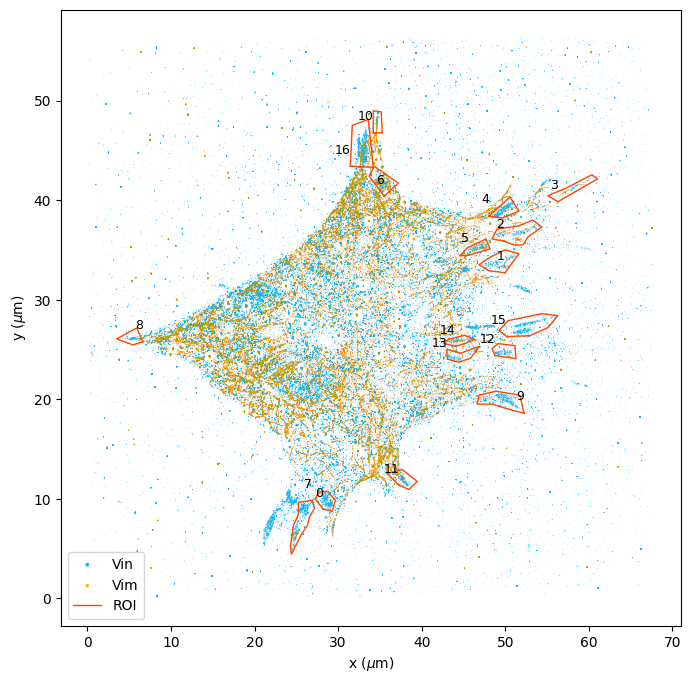

Ready


In [375]:
import matplotlib.pyplot as plt
import json

# Assuming data_table_ch1_range, data_table_ch2_range, ch_name, ch_col, and file_path are defined earlier

x1 = data_table_ch1_range['XPosition_mkm']
y1 = data_table_ch1_range['YPosition_mkm']

x2 = data_table_ch2_range['XPosition_mkm']
y2 = data_table_ch2_range['YPosition_mkm']

fig1, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x1, y1, s=0.1, label=ch_name[0][:3], marker='.', color=ch_col[0], edgecolors='none')
ax.scatter(x2, y2, s=0.05, label=ch_name[1][:3], marker='.', color=ch_col[1], alpha=0.8, edgecolors='none')

plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]

# Read the JSON file
with open(file_path, 'r') as file:
    loaded_datasets = json.load(file)

# Access the loaded datasets and add text annotations
for dataset in loaded_datasets:
    roi_name = dataset['ROI_name']
    coordinates = dataset['coordinates']

    # Flatten coordinates if nested
    if any(isinstance(coord_list, list) for coord_list in coordinates) and all(isinstance(coord, list) for coord_list in coordinates for coord in coord_list):
        coordinates = [coord for sublist in coordinates for coord in sublist]

    x_coords, y_coords = zip(*coordinates)  # Unpack the list of (x, y) tuples

    ax.plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), linestyle='-', linewidth=1, c='orangered', label='ROI')

    # Determine the text label
    roi_label = roi_name[4:]
    text_x, text_y = x_coords[0], y_coords[0]+1
    ax.text(text_x, text_y, roi_label, fontsize=9, color='black', ha='right', va='bottom')  
roi_legend, = ax.plot([], [], linestyle='-', linewidth=1, color='orangered', label='ROI')

lgnd = plt.legend(handles=[scatter1, scatter2, roi_legend], loc="lower left", scatterpoints=1, fontsize=10)

lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
fig1.savefig(parent_dir + "//all_ROIs_on_the_cell_bothCh_2_ROIS.png", dpi=300)
print('Results are saved to the folder:', parent_dir + "//all_ROIs_on_the_cell_bothCh_2_ROIS.png")

plt.show()
print("Ready")